In [1]:
%load_ext autoreload
%autoreload 2

import json, os

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.ticker as mtick
import matplotlib as mpl
from matplotlib.patches import FancyArrowPatch

from Experiment import Experiment2D
from figure_functions import compute_rolling_average, prediction_compare_plot, latent_space_plot, loss_boxplot
from figure_functions import training_loss_epochs_plot, waterfall_plot, generate_GL_plot, generate_G_plot, summary_boxplot

#from figure_functions import compute_rolling_average, prediction_compare_plot, latent_space_plot, loss_boxplot
#from figure_functions import training_loss_epochs_plot

# New things: waterfall_plot, generate_GL_plot, generate_G_plot, summary_boxplot

In [2]:
# Set plotting parameters
global_params = {'figure.dpi': 300,
                 'text.usetex': True,
                 'text.latex.preamble': r"\usepackage{amsmath}",
                 'font.family': 'sans-serif',
                 'savefig.dpi': 300,
                 'savefig.bbox': 'tight',
                 'savefig.pad_inches': 0.025,
                 'savefig.transparent': True,
                 #'font.sans-serif': 'Computer Modern Roman',
                }

full_params = {'figure.figsize': (7.3, 3.65),
               'figure.titlesize': 12,
               'axes.labelsize': 10,
               'axes.titlesize': 12,
               'legend.fontsize': 10,
               'xtick.labelsize': 12,
               'ytick.labelsize': 12,
              }

half_params = {'figure.figsize': (3.5, 2.5),
               'figure.titlesize': 10,
               'lines.linewidth' : 1,
               'lines.markersize' : 6,
               'lines.markeredgewidth': 0.5,
               'axes.labelsize': 9,
               'axes.titlesize': 9,
               'axes.linewidth': 0.5,
               'legend.fontsize': 9,
               'xtick.labelsize': 9,
               'ytick.labelsize': 9,
               'xtick.major.width': 0.5,
               'ytick.major.width': 0.7,
               'ytick.minor.width': 0.5,
               'ytick.major.pad': 0.0,
              }

# Add global parameters to the full_params and half_params dictionaries
full_params.update(global_params)
half_params.update(global_params)

# Set up boxplot-specific options
boxplot_params={'boxplot.boxprops.linewidth': 0.5,
                'boxplot.whiskerprops.linewidth': 0.5,
                'boxplot.capprops.linewidth': 0.5,
                'boxplot.medianprops.linewidth' : 0.5,
               }

# Boolean determining if figures should be saved 
saveallfigs = True

In [3]:
# This version has equally spaces colorbar ticks and scales naturally for colormap range

from matplotlib.cm import ScalarMappable

def plot_predict_vs_true(i, pred_u, pred_f, u, f, fig, ax1, ax2, cbticksu, cbticksF, cbticksDu, cbticksDF):
    
    # Grab the 'true' value
    true_u = u[i,:,:]
    true_F = f[i,:,:]

    # And predicted value
    predict_u = pred_u[i,:,:]
    predict_F = pred_f[i,:,:]

    # create a space vector
    x = np.linspace(0,2*np.pi, predict_u.shape[0])
    X, Y = np.meshgrid(x,x)
    
    # Set colorbar limits
    uMax = np.max(np.vstack((true_u, predict_u)))
    uMin = np.min(np.vstack((true_u, predict_u)))
    FMax = np.max(np.vstack((true_F, predict_F)))
    FMin = np.min(np.vstack((true_F, predict_F)))
    uInf = np.max((abs(uMax), abs(uMin)))
    FInf = np.max((abs(FMax), abs(FMin)))
    
    Diff_u = (true_u-predict_u)/uInf
    DuMax = np.max(Diff_u)
    DuMin = np.min(Diff_u)
    
    Diff_F = (true_F-predict_F)/FInf
    DFMax = np.max(Diff_F)
    DFMin = np.min(Diff_F)
    
    # Create the figures
    ax = ax1[0]
    cont = ax.contourf(X, Y, true_u, levels=100, vmin=uMin, vmax=uMax)
    if not cbticksu:
        cbar = fig.colorbar(cont, ax=ax, format='%.0e')
        cbar.ax.locator_params(nbins=3)
        print("Min u: {:.2e}".format(uMin))
        print("Max u: {:.2e}".format(uMax))
    else:
        cbar = fig.colorbar(ScalarMappable(norm=cont.norm, cmap=cont.cmap), ax=ax, ticks=[float(i) for i in cbticksu])
        cbar.ax.set_yticklabels(cbticksu)  
    ax.set_title(r'True')
    ax.set_ylabel(r"$\mathbf{u}(x)$")
    ax.set_xlim([0,2*np.pi])
    ax.set_yticks([0, np.pi, 2*np.pi])
    ax.set_yticklabels(["0", r"$\pi$", r"$2\pi$"])
    ax.set_ylim([0,2*np.pi])

    ax = ax2[0]
    cont = ax.contourf(X, Y, true_F, levels=100, vmin=FMin, vmax=FMax)
    if not cbticksF:
        cbar = fig.colorbar(cont, ax=ax, format='%.0e')
        cbar.ax.locator_params(nbins=3)
        print("Min F: {:.2e}".format(FMin))
        print("Max F: {:.2e}".format(FMax))
    else:
        cbar = fig.colorbar(ScalarMappable(norm=cont.norm, cmap=cont.cmap), ax=ax, ticks=[float(i) for i in cbticksF])
        cbar.ax.set_yticklabels(cbticksF) 
    ax.set_ylabel(r"$\mathbf{F}(x)$")
    ax.set_xticks([0, np.pi, 2*np.pi])
    ax.set_xticklabels(["0", r"$\pi$", r"$2\pi$"])
    ax.set_xlim([0,2*np.pi])
    ax.set_yticks([0, np.pi, 2*np.pi])
    ax.set_yticklabels(["0", r"$\pi$", r"$2\pi$"])
    ax.set_ylim([0,2*np.pi])
    
    ax = ax1[1]
    cont = ax.contourf(X, Y, predict_u, levels=100, vmin=uMin, vmax=uMax)
    if not cbticksu:
        cbar = fig.colorbar(cont, ax=ax, format='%.0e')
        cbar.ax.locator_params(nbins=3)
    else:
        cbar = fig.colorbar(ScalarMappable(norm=cont.norm, cmap=cont.cmap), ax=ax, ticks=[float(i) for i in cbticksu])
        cbar.ax.set_yticklabels(cbticksu)  
    ax.set_title(r'Predicted')
    ax.set_xlim([0,2*np.pi])
    ax.set_ylim([0,2*np.pi])

    ax = ax2[1]
    cont = ax.contourf(X, Y, predict_F, levels=100, vmin=FMin, vmax=FMax)
    if not cbticksF:
        cbar = fig.colorbar(cont, ax=ax, format='%.0e')
        cbar.ax.locator_params(nbins=3)
    else:
        cbar = fig.colorbar(ScalarMappable(norm=cont.norm, cmap=cont.cmap), ax=ax, ticks=[float(i) for i in cbticksF])
        cbar.ax.set_yticklabels(cbticksF) 
    ax.set_xticks([0, np.pi, 2*np.pi])
    ax.set_xticklabels(["0", r"$\pi$", r"$2\pi$"])
    ax.set_xlim([0,2*np.pi])
    ax.set_ylim([0,2*np.pi])
    
    ax = ax1[2]
    cont = ax.contourf(X, Y, Diff_u, 100, vmin=DuMin, vmax=DuMax)
    if not cbticksDu:
        cbar = fig.colorbar(cont, ax=ax, format='%.0e')
        cbar.ax.locator_params(nbins=3)
        print("Min u difference: {:.2e}".format(DuMin))
        print("Max u difference: {:.2e}".format(DuMax))
    else:
        cbar = fig.colorbar(ScalarMappable(norm=cont.norm, cmap=cont.cmap), ax=ax, ticks=[float(i) for i in cbticksDu])
        cbar.ax.set_yticklabels(cbticksDu) 
    ax.set_title('Difference')
    ax.set_xlim([0,2*np.pi])
    ax.set_ylim([0,2*np.pi])

    ax = ax2[2]
    cont = ax.contourf(X, Y, Diff_F, 100, vmin=DFMin, vmax=DFMax)
    if not cbticksDF:
        cbar = fig.colorbar(cont, ax=ax, format='%.0e')
        cbar.ax.locator_params(nbins=3)
        print("Min F difference: {:.2e}".format(DFMin))
        print("Max F difference: {:.2e}".format(DFMax))
    else:
        cbar = fig.colorbar(ScalarMappable(norm=cont.norm, cmap=cont.cmap), ax=ax, ticks=[float(i) for i in cbticksDF])
        cbar.ax.set_yticklabels(cbticksDF) 
    ax.set_xticks([0, np.pi, 2*np.pi])
    ax.set_xticklabels(["0", r"$\pi$", r"$2\pi$"])
    ax.set_xlim([0,2*np.pi])
    ax.set_ylim([0,2*np.pi])
    
    # Change spacing
    fig.subplots_adjust(wspace=0.3, hspace=0.2)#, left=0.05, right=0.07)

In [4]:
# This version has all colormaps and colorbars symmetric about zero

#from matplotlib.cm import ScalarMappable
#
#def plot_predict_vs_true(i, pred_u, pred_f, u, f, fig, ax1, ax2, cbticksu, cbticksF, cbticksDu, cbticksDF):
#    
#    # Grab the 'true' value
#    true_u = u[i,:,:]
#    true_F = f[i,:,:]
#
#    # And predicted value
#    predict_u = pred_u[i,:,:]
#    predict_F = pred_f[i,:,:]
#
#    # create a space vector
#    x = np.linspace(0,2*np.pi, predict_u.shape[0])
#    X, Y = np.meshgrid(x,x)
#    
#    # Set colorbar limits
#    uMax = np.max(np.vstack((true_u, predict_u)))
#    uMin = np.min(np.vstack((true_u, predict_u)))
#    FMax = np.max(np.vstack((true_F, predict_F)))
#    FMin = np.min(np.vstack((true_F, predict_F)))
#    uInf = np.max((abs(uMax), abs(uMin)))
#    FInf = np.max((abs(FMax), abs(FMin)))
#    
#    Diff_u = (true_u-predict_u)/uInf
#    DuMax = np.max(Diff_u)
#    DuMin = np.min(Diff_u)
#    DuInf = np.max((abs(DuMax), abs(DuMin)))
#    
#    Diff_F = (true_F-predict_F)/FInf
#    DFMax = np.max(Diff_F)
#    DFMin = np.min(Diff_F)
#    DFInf = np.max((abs(DFMax), abs(DFMin)))
#    
#    # Create the figures
#    ax = ax1[0]
#    cont = ax.contourf(X, Y, true_u, levels=100, vmin=-uInf, vmax=uInf)
#    if not cbticksu:
#        cbar = fig.colorbar(cont, ax=ax, format='%.0e')
#        cbar.ax.locator_params(nbins=3)
#        print("Min u: {:.2e}".format(uMin))
#        print("Max u: {:.2e}".format(uMax))
#    else:
#        cbar = fig.colorbar(ScalarMappable(norm=cont.norm, cmap=cont.cmap), ax=ax, ticks=[float(i) for i in cbticksu])
#        cbar.ax.set_yticklabels(cbticksu)  
#    ax.set_title(r'True')
#    ax.set_ylabel(r"$\mathbf{u}(x)$")
#    ax.set_xlim([0,2*np.pi])
#    ax.set_yticks([0, np.pi, 2*np.pi])
#    ax.set_yticklabels(["0", r"$\pi$", r"$2\pi$"])
#    ax.set_ylim([0,2*np.pi])
#
#    ax = ax2[0]
#    cont = ax.contourf(X, Y, true_F, levels=100, vmin=-FInf, vmax=FInf)
#    if not cbticksF:
#        cbar = fig.colorbar(cont, ax=ax, format='%.0e')
#        cbar.ax.locator_params(nbins=3)
#        print("Min F: {:.2e}".format(FMin))
#        print("Max F: {:.2e}".format(FMax))
#    else:
#        cbar = fig.colorbar(ScalarMappable(norm=cont.norm, cmap=cont.cmap), ax=ax, ticks=[float(i) for i in cbticksF])
#        cbar.ax.set_yticklabels(cbticksF) 
#    ax.set_ylabel(r"$\mathbf{F}(x)$")
#    ax.set_xticks([0, np.pi, 2*np.pi])
#    ax.set_xticklabels(["0", r"$\pi$", r"$2\pi$"])
#    ax.set_xlim([0,2*np.pi])
#    ax.set_yticks([0, np.pi, 2*np.pi])
#    ax.set_yticklabels(["0", r"$\pi$", r"$2\pi$"])
#    ax.set_ylim([0,2*np.pi])
#    
#    ax = ax1[1]
#    cont = ax.contourf(X, Y, predict_u, levels=100, vmin=-uInf, vmax=uInf)
#    if not cbticksu:
#        cbar = fig.colorbar(cont, ax=ax, format='%.0e')
#        cbar.ax.locator_params(nbins=3)
#    else:
#        cbar = fig.colorbar(ScalarMappable(norm=cont.norm, cmap=cont.cmap), ax=ax, ticks=[float(i) for i in cbticksu])
#        cbar.ax.set_yticklabels(cbticksu)  
#    ax.set_title(r'Predicted')
#    ax.set_xlim([0,2*np.pi])
#    ax.set_ylim([0,2*np.pi])
#
#    ax = ax2[1]
#    cont = ax.contourf(X, Y, predict_F, levels=100, vmin=-FInf, vmax=FInf)
#    if not cbticksF:
#        cbar = fig.colorbar(cont, ax=ax, format='%.0e')
#        cbar.ax.locator_params(nbins=3)
#    else:
#        cbar = fig.colorbar(ScalarMappable(norm=cont.norm, cmap=cont.cmap), ax=ax, ticks=[float(i) for i in cbticksF])
#        cbar.ax.set_yticklabels(cbticksF) 
#    ax.set_xticks([0, np.pi, 2*np.pi])
#    ax.set_xticklabels(["0", r"$\pi$", r"$2\pi$"])
#    ax.set_xlim([0,2*np.pi])
#    ax.set_ylim([0,2*np.pi])
#    
#    ax = ax1[2]
#    cont = ax.contourf(X, Y, Diff_u, 100, vmin=-DuInf, vmax=DuInf)
#    if not cbticksDu:
#        cbar = fig.colorbar(cont, ax=ax, format='%.0e')
#        cbar.ax.locator_params(nbins=3)
#        print("Min u difference: {:.2e}".format(DuMin))
#        print("Max u difference: {:.2e}".format(DuMax))
#    else:
#        cbar = fig.colorbar(ScalarMappable(norm=cont.norm, cmap=cont.cmap), ax=ax, ticks=[float(i) for i in cbticksDu])
#        cbar.ax.set_yticklabels(cbticksDu) 
#    ax.set_title('Difference')
#    ax.set_xlim([0,2*np.pi])
#    ax.set_ylim([0,2*np.pi])
#
#    ax = ax2[2]
#    cont = ax.contourf(X, Y, Diff_F, 100, vmin=-DFInf, vmax=DFInf)
#    if not cbticksDF:
#        cbar = fig.colorbar(cont, ax=ax, format='%.0e')
#        cbar.ax.locator_params(nbins=3)
#        print("Min F difference: {:.2e}".format(DFMin))
#        print("Max F difference: {:.2e}".format(DFMax))
#    else:
#        cbar = fig.colorbar(ScalarMappable(norm=cont.norm, cmap=cont.cmap), ax=ax, ticks=[float(i) for i in cbticksDF])
#        cbar.ax.set_yticklabels(cbticksDF) 
#    ax.set_xticks([0, np.pi, 2*np.pi])
#    ax.set_xticklabels(["0", r"$\pi$", r"$2\pi$"])
#    ax.set_xlim([0,2*np.pi])
#    ax.set_ylim([0,2*np.pi])
#    
#    # Change spacing
#    fig.subplots_adjust(wspace=0.3, hspace=0.2)#, left=0.05, right=0.07)

In [5]:
def generate_compare_plot(expt, data_name, 
                          cbticksu=[[],[],[]], cbticksF=[[],[],[]], 
                          cbticksDu=[[],[],[]], cbticksDF=[[],[],[]],
                          saveallfigs=False):
    
    modes = ['Best', 'Mean', 'Worst']
    
    u = expt.data['{}_u'.format(data_name)]
    F = expt.data['{}_f'.format(data_name)]
    
    for j in range(3):
        mode = modes[j]   
        
        fig, [ax1, ax2] = plt.subplots(2,3, sharex=True, sharey=True)
        i = expt.find_sample(dataset_name=data_name, mode=mode)
        u_pred, F_pred = expt.predict_uF(u, F)

        plot_predict_vs_true(i, u_pred, F_pred, u, F, fig, ax1, ax2, 
                             cbticksu[j], cbticksF[j], cbticksDu[j], cbticksDF[j])
        
        if saveallfigs:
            plt.savefig("{}-{}-{}pred.png".format(expt.name, mode, data_name), transparent=True)
    
        plt.show()

In [6]:
# Load up the different experiments for analysis
s3 = Experiment2D(experiment_name="S3-NLP-Expt1-L200-a", data_file_prefix='S3-NLP')

expt = s3

Min u: -3.12e-01
Max u: 3.12e-01
Min F: -6.01e+00
Max F: 6.01e+00
Min u difference: -4.86e-03
Max u difference: 3.03e-03
Min F difference: -1.81e-02
Max F difference: 2.23e-02


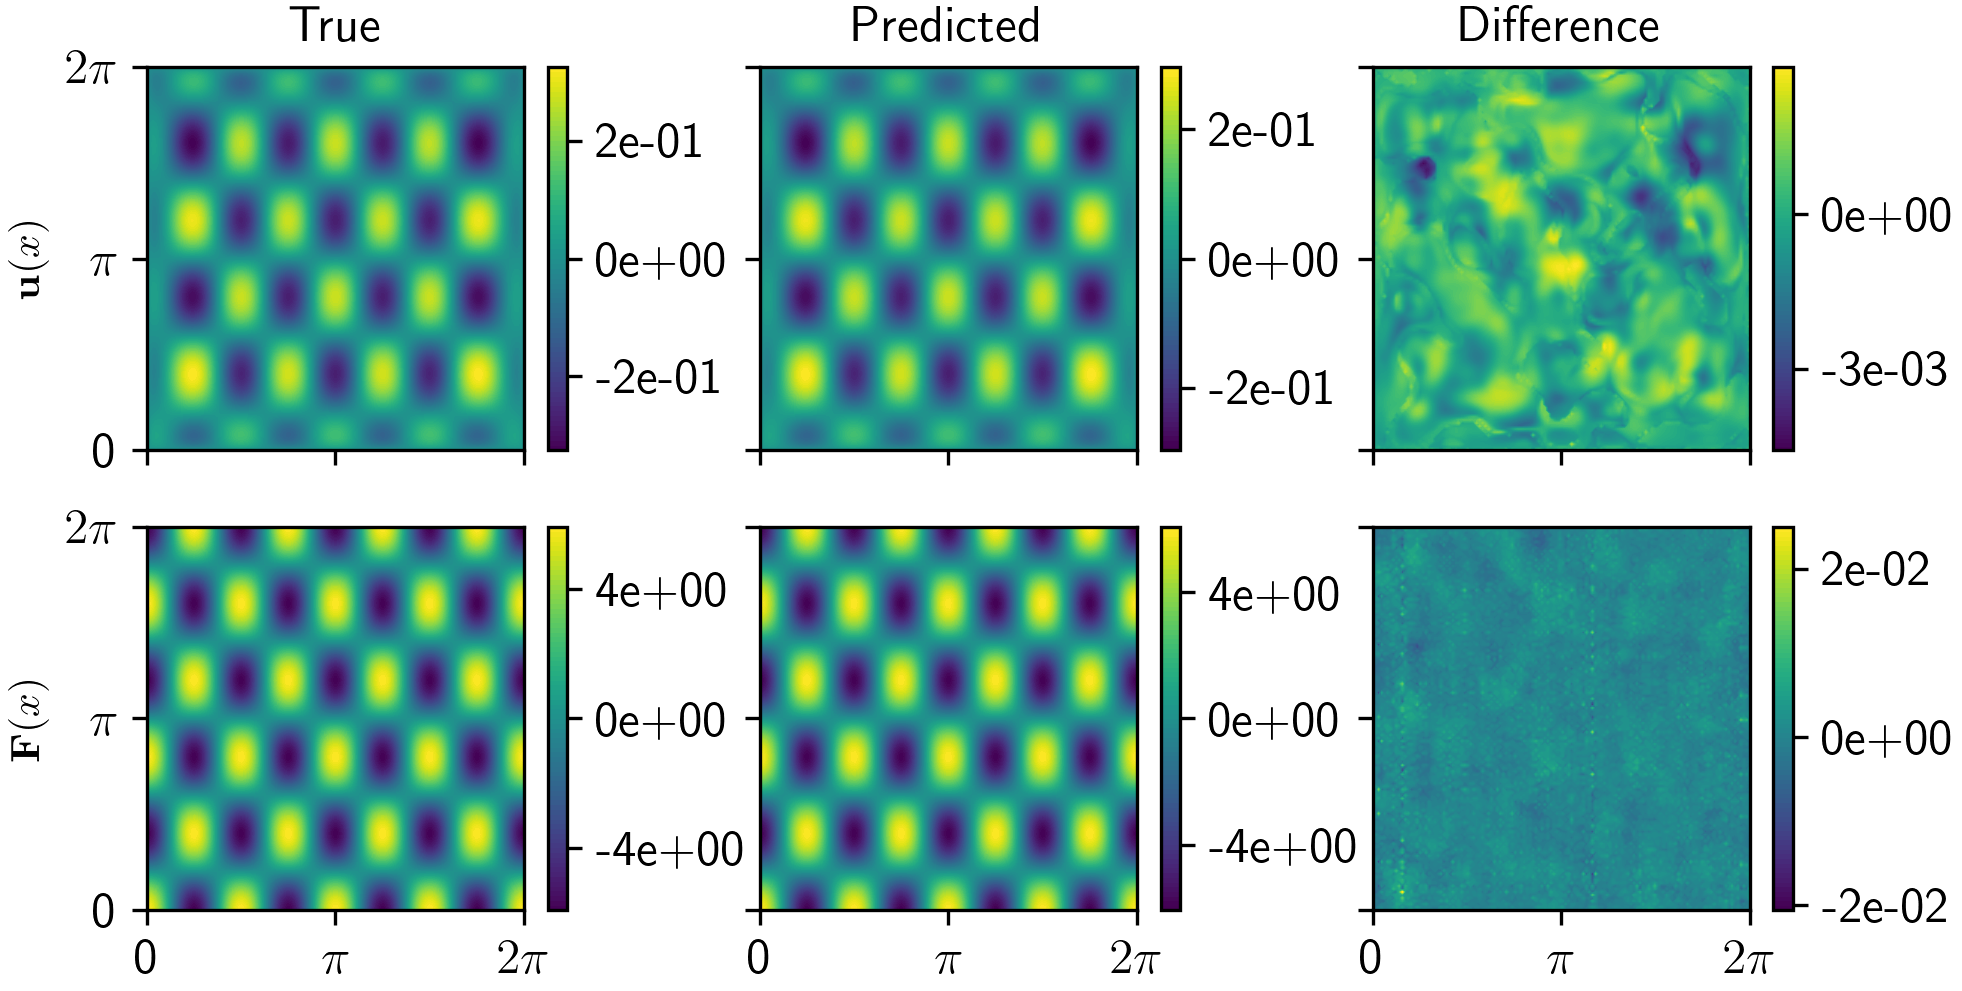

Min u: -6.66e-03
Max u: 3.13e+00
Min F: -5.98e-01
Max F: 1.51e+01
Min u difference: -1.95e-02
Max u difference: 1.43e-02
Min F difference: -2.29e-02
Max F difference: 4.40e-02


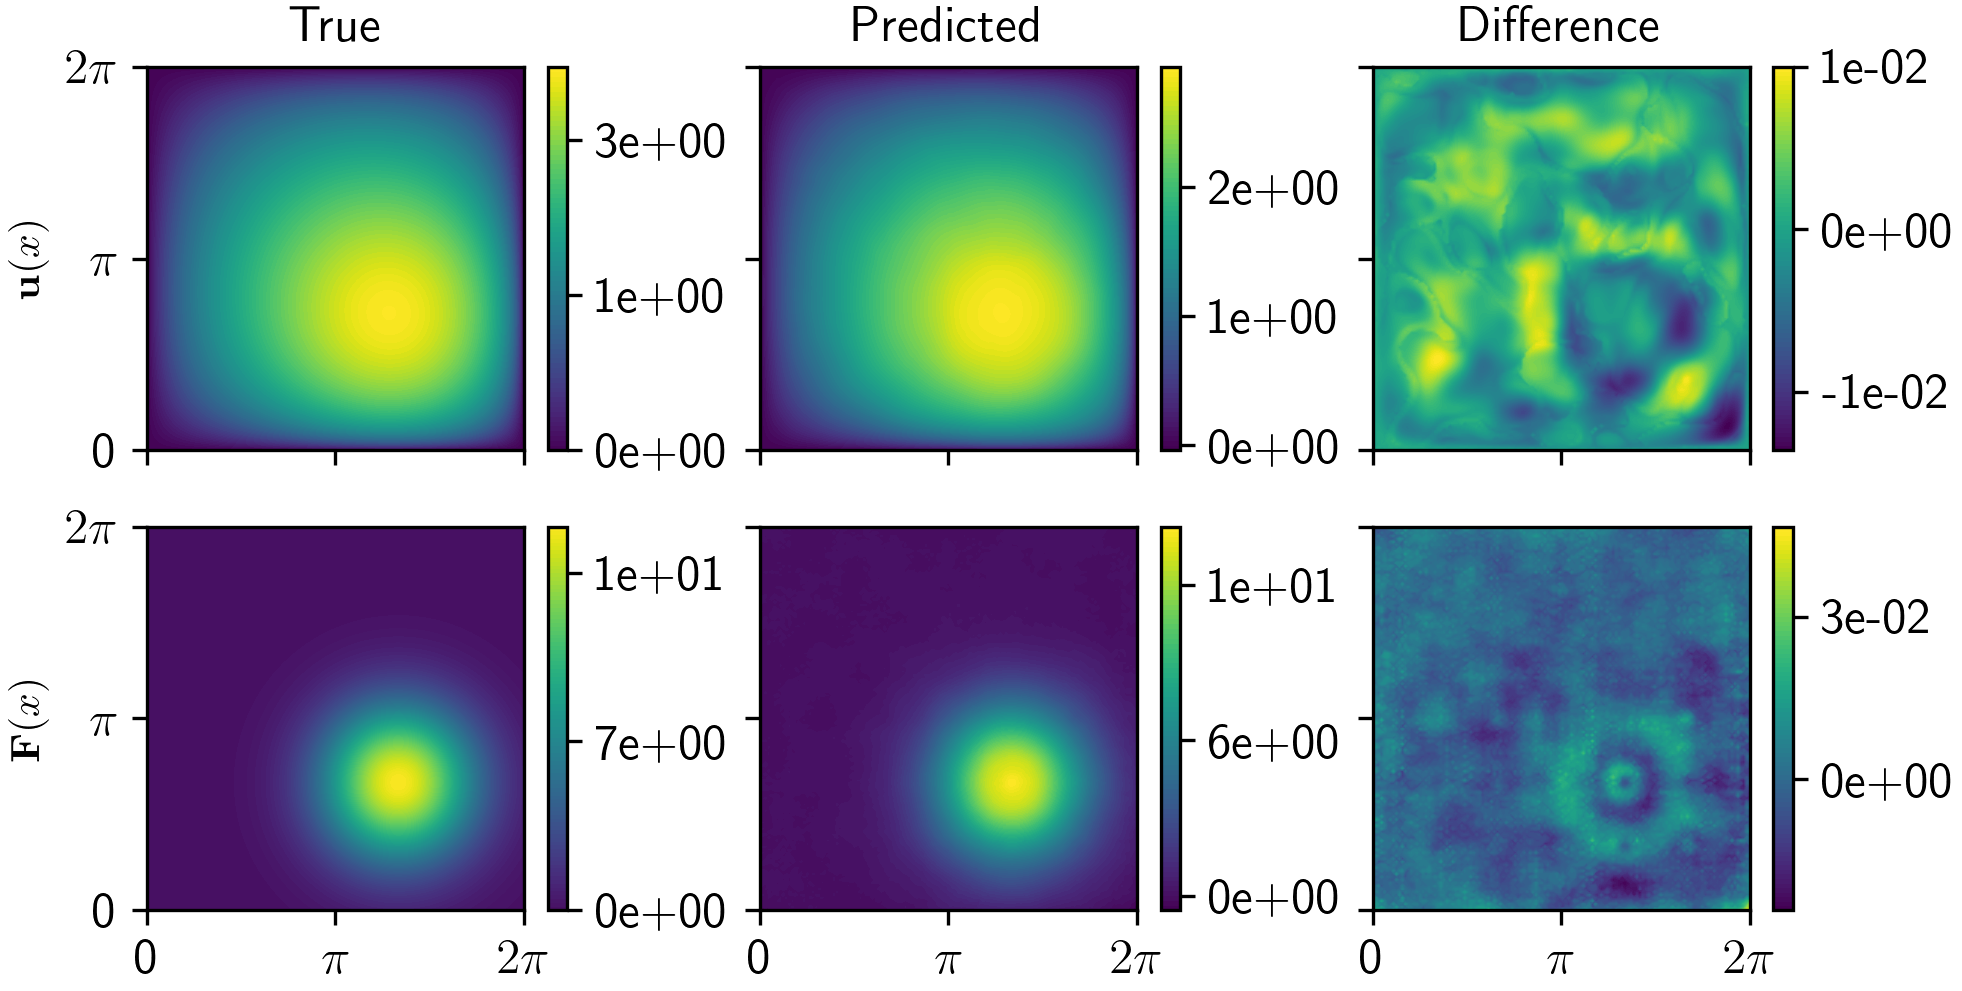

Min u: -8.55e-01
Max u: 3.92e-03
Min F: -9.32e+00
Max F: 3.80e-01
Min u difference: -6.25e-02
Max u difference: 4.50e-02
Min F difference: -7.39e-02
Max F difference: 4.67e-01


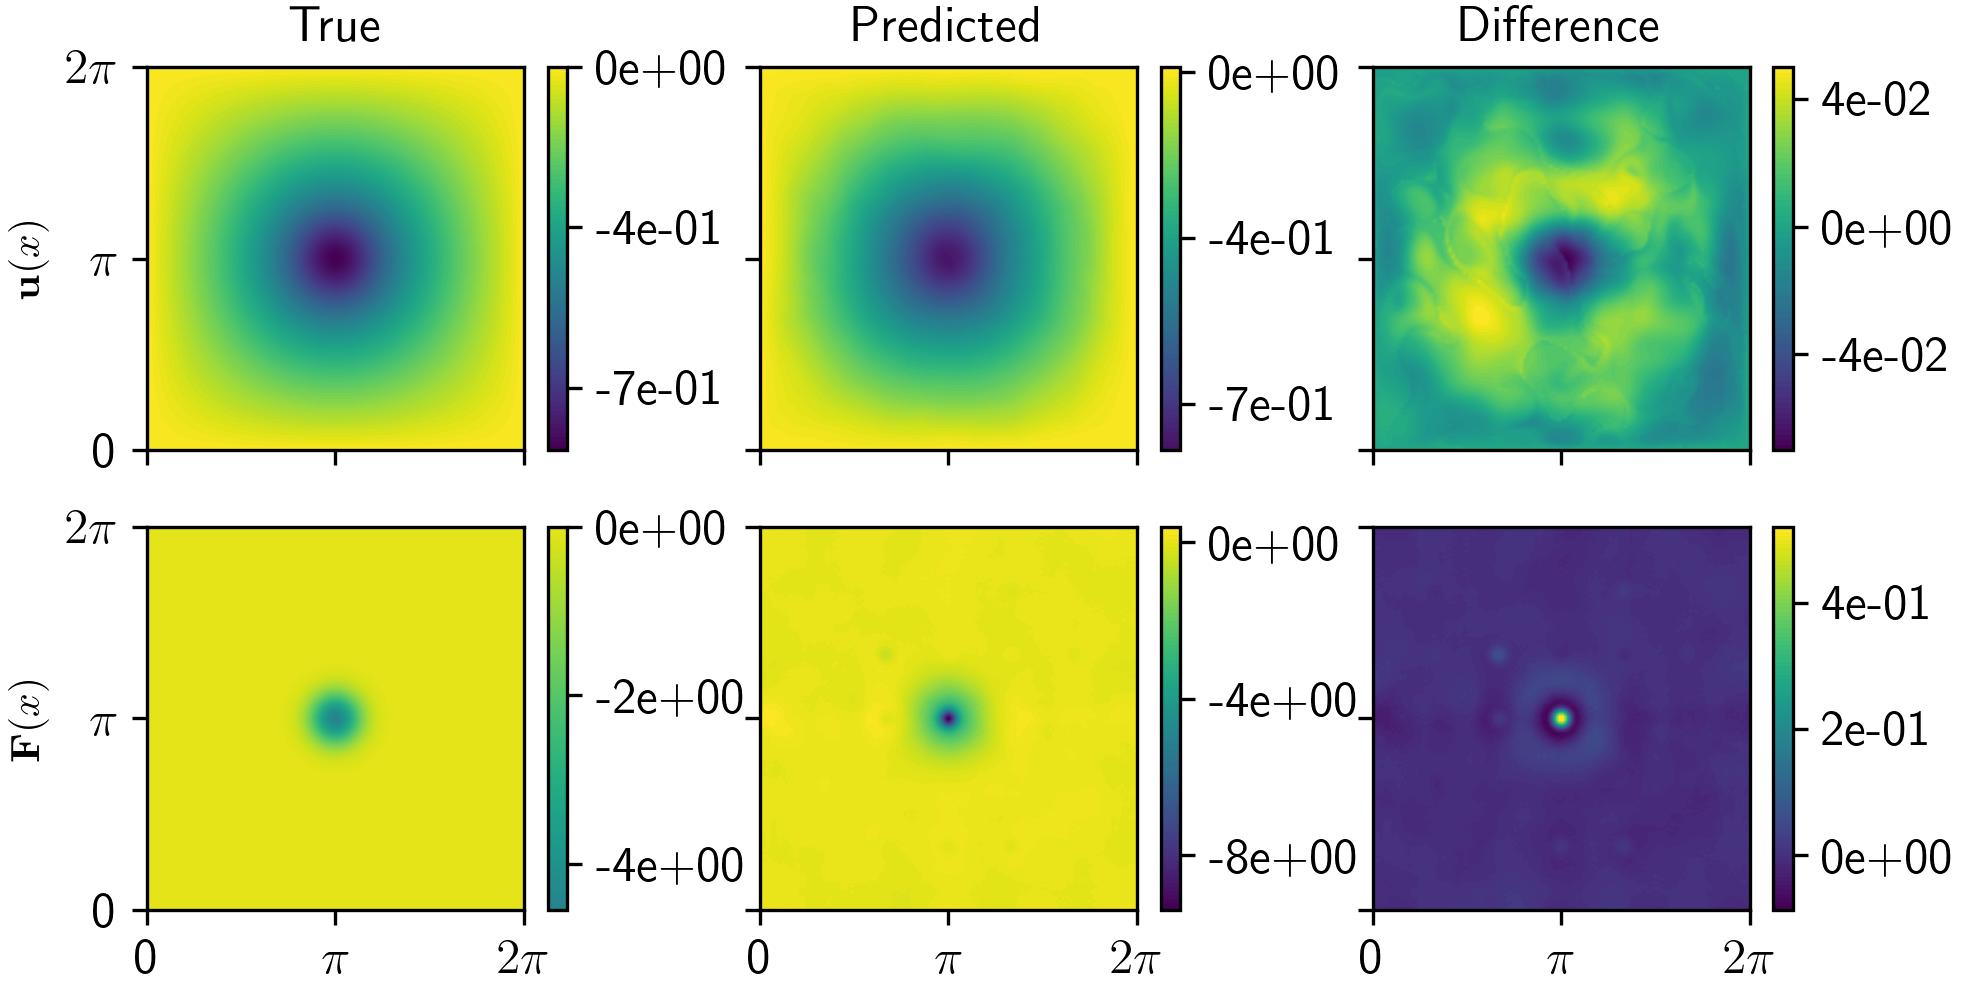

In [7]:
# Run to find reasonable values for the colorbars

plt.rcdefaults()
plt.rcParams.update(full_params)

generate_compare_plot(expt, 'val', saveallfigs=False)

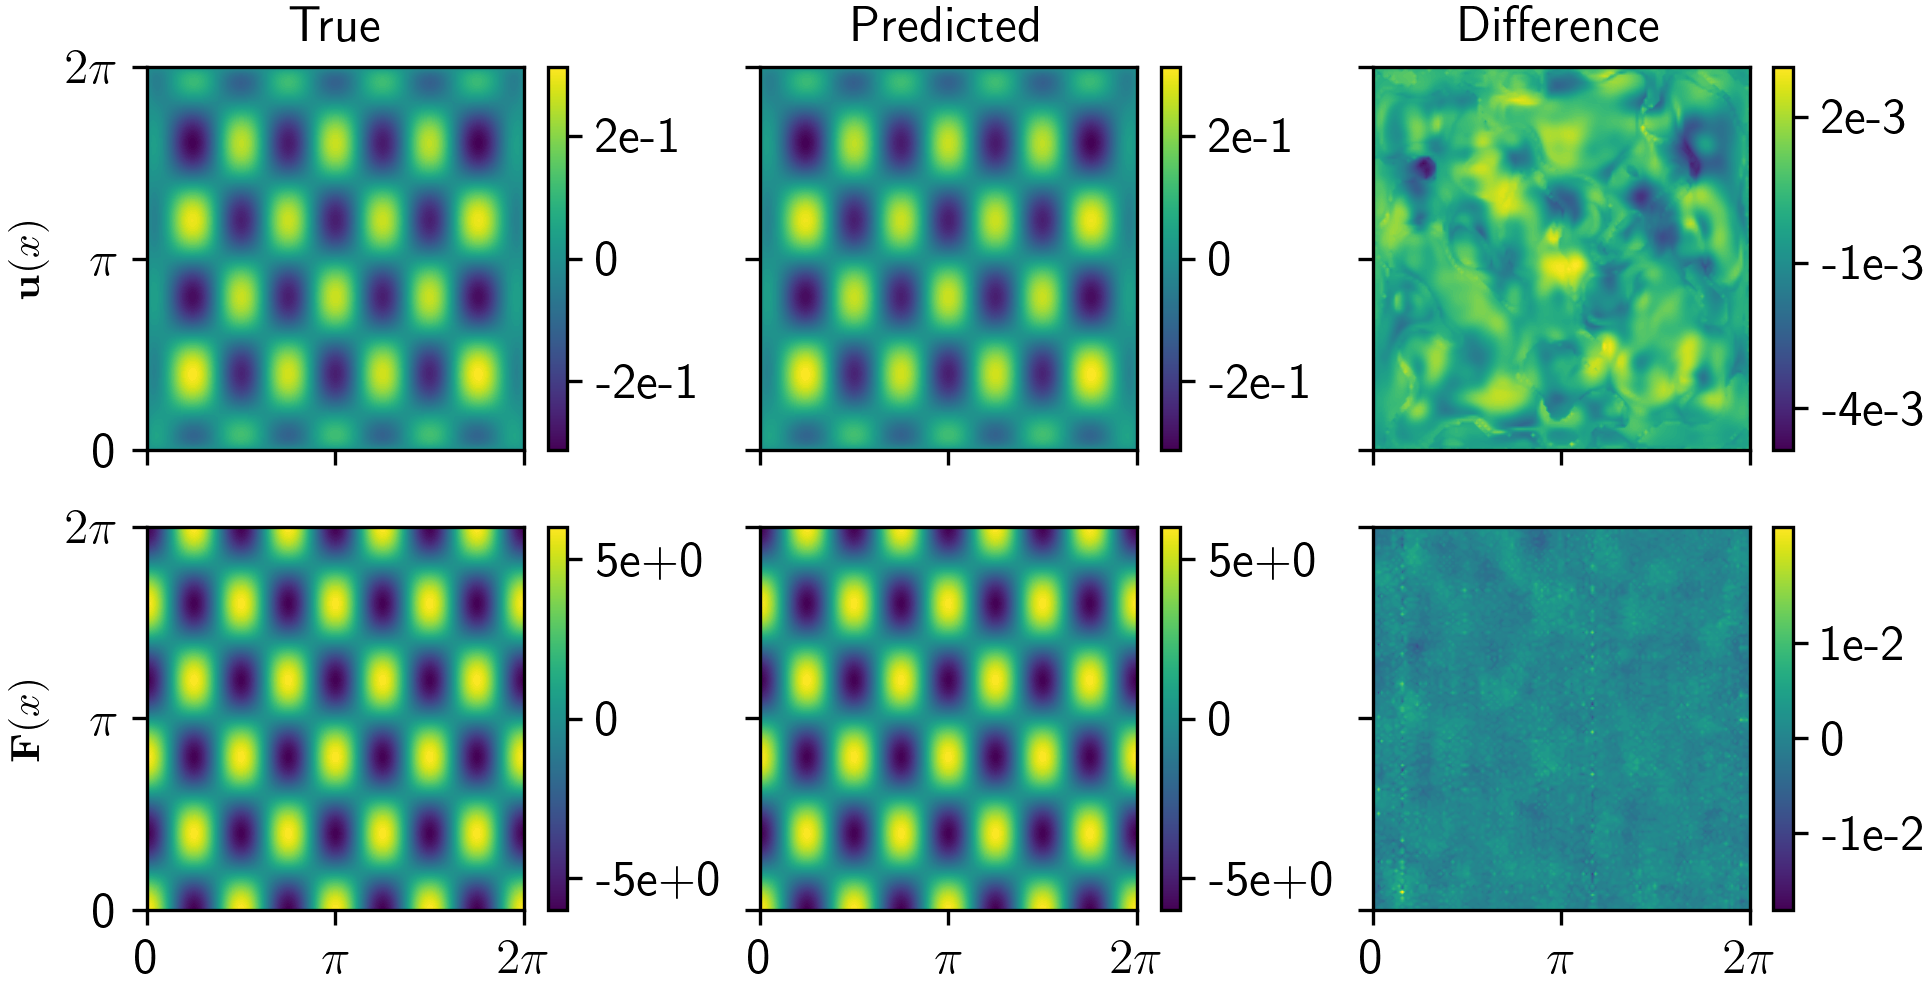

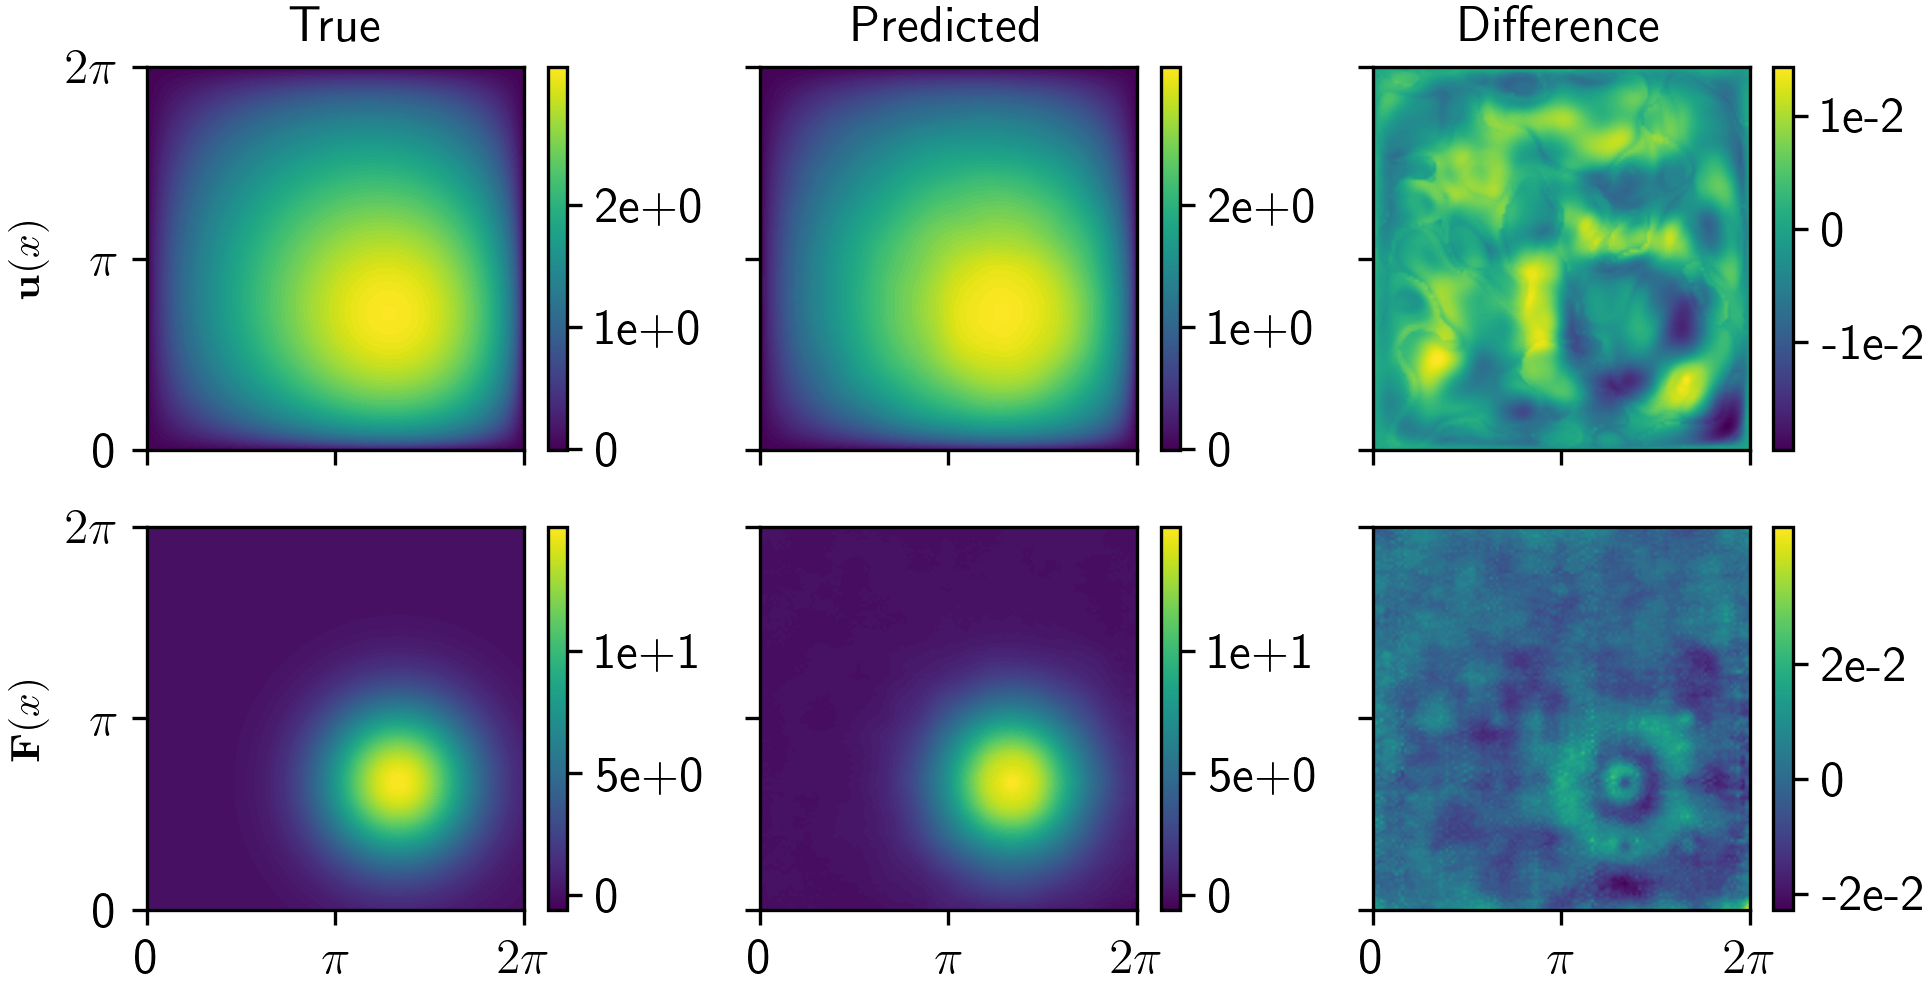

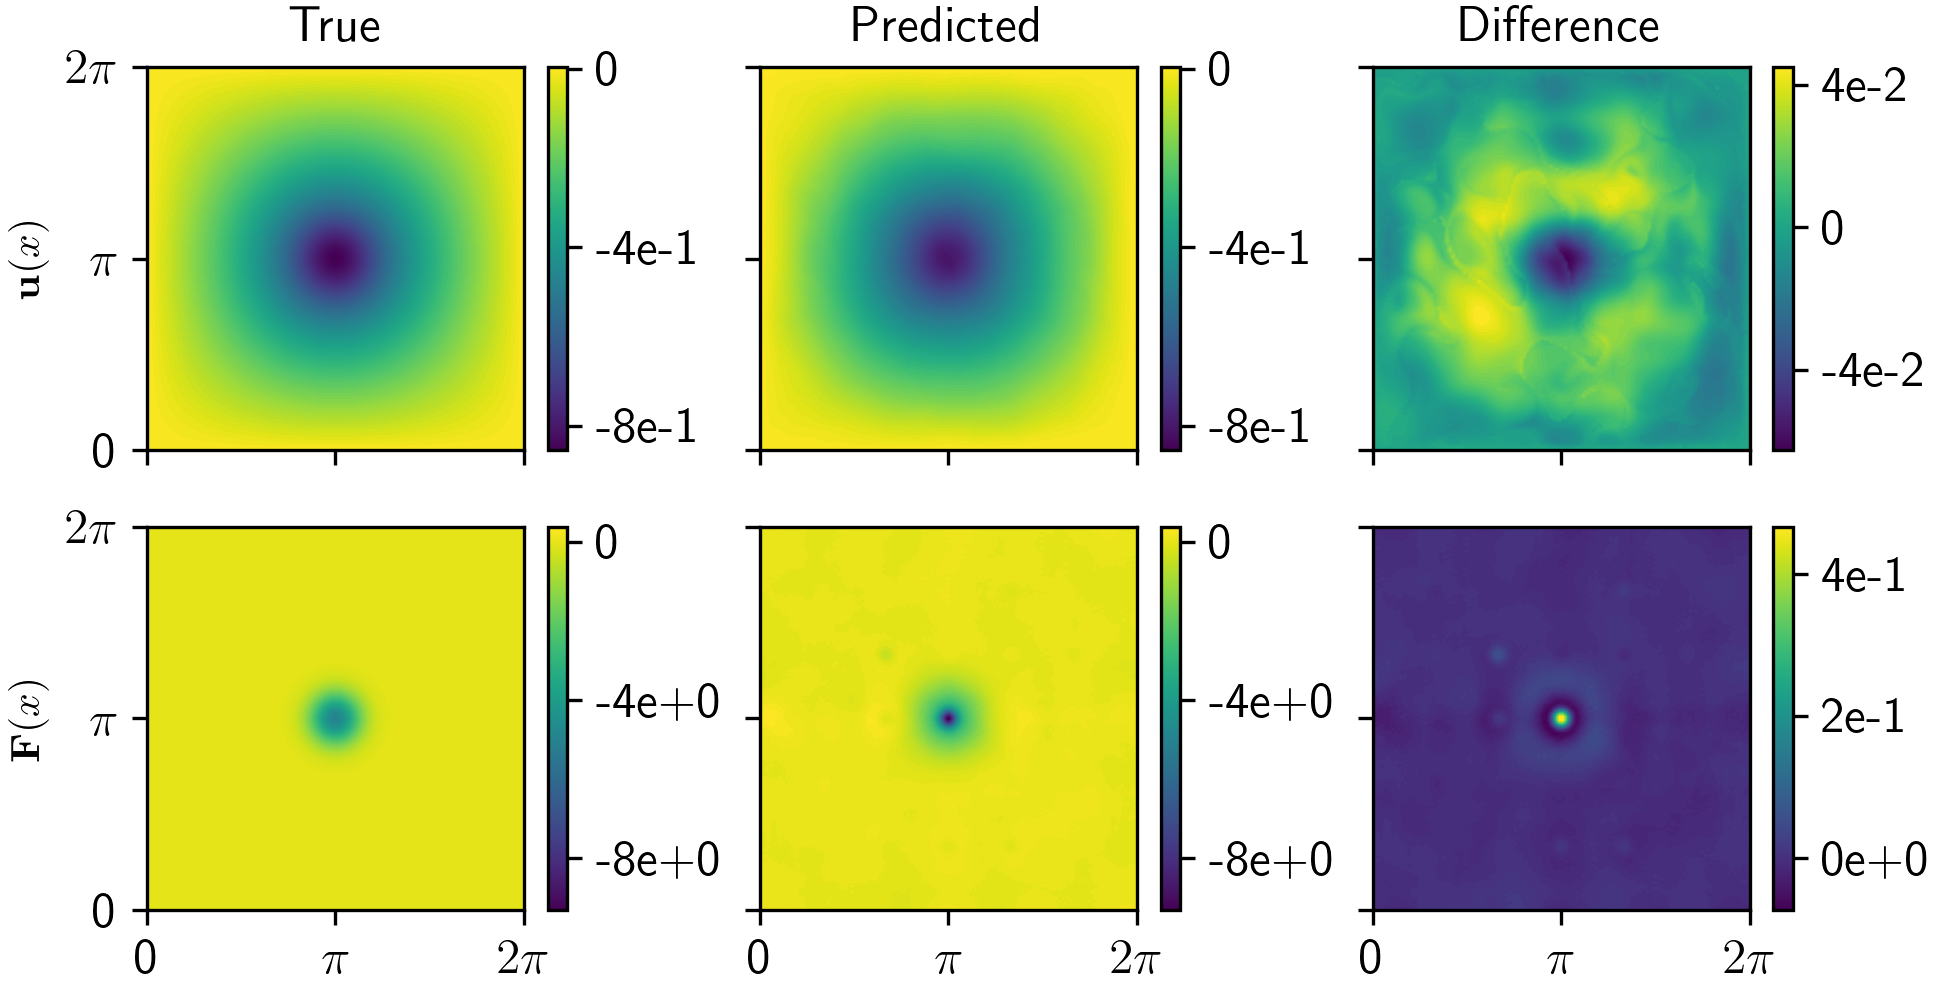

In [8]:
# Now manually input the values for the colorbars to ensure equal spacing and proper formatting

plt.rcdefaults()
plt.rcParams.update(full_params)

cbticksu_best = ['-2e-1', '0', '2e-1'] 
cbticksF_best = ['-5e+0', '0', '5e+0'] 
cbticksDu_best = ['-4e-3', '-1e-3', '2e-3']
cbticksDF_best = ['-1e-2', '0', '1e-2']

cbticksu_mean = ['0', '1e+0', '2e+0'] 
cbticksF_mean = ['0', '5e+0', '1e+1'] 
cbticksDu_mean = ['-1e-2', '0', '1e-2']
cbticksDF_mean = ['-2e-2', '0', '2e-2']

cbticksu_worst = ['-8e-1', '-4e-1', '0'] 
cbticksF_worst = ['-8e+0', '-4e+0', '0'] 
cbticksDu_worst = ['-4e-2', '0', '4e-2']
cbticksDF_worst = ['0e+0', '2e-1', '4e-1']

cbticksu = [cbticksu_best, cbticksu_mean, cbticksu_worst]
cbticksF = [cbticksF_best, cbticksF_mean, cbticksF_worst]
cbticksDu = [cbticksDu_best, cbticksDu_mean, cbticksDu_worst]
cbticksDF = [cbticksDF_best, cbticksDF_mean, cbticksDF_worst]

generate_compare_plot(expt, 'val', cbticksu, cbticksF, cbticksDu, cbticksDF, saveallfigs)

In [9]:
# Now manually input the values for the colorbars to ensure symmetry and proper formatting

#plt.rcdefaults()
#plt.rcParams.update(full_params)
#
#cbticksu_best = ['-3e-1', '0', '3e-1'] 
#cbticksF_best = ['-6e+0', '0', '6e+0'] 
#cbticksDu_best = ['-4e-3', '0', '4e-3']
#cbticksDF_best = ['-2e-2', '0', '2e-2']
#
#cbticksu_mean = ['-3e+0', '0', '3e+0'] 
#cbticksF_mean = ['-1e+1', '0', '1e+1'] 
#cbticksDu_mean = ['-1e-2', '0', '1e-2']
#cbticksDF_mean = ['-4e-2', '0', '4e-2']
#
#cbticksu_worst = ['-8e-1', '0', '8e-1'] 
#cbticksF_worst = ['-9e+0', '0', '9e+0'] 
#cbticksDu_worst = ['-6e-2', '0', '6e-2']
#cbticksDF_worst = ['-4e-1', '0', '4e-1']
#
#cbticksu = [cbticksu_best, cbticksu_mean, cbticksu_worst]
#cbticksF = [cbticksF_best, cbticksF_mean, cbticksF_worst]
#cbticksDu = [cbticksDu_best, cbticksDu_mean, cbticksDu_worst]
#cbticksDF = [cbticksDF_best, cbticksDF_mean, cbticksDF_worst]
#
#generate_compare_plot(expt, 'val', cbticksu, cbticksF, cbticksDu, cbticksDF, saveallfigs)

Min u: -3.02e-01
Max u: 3.02e-01
Min F: -5.81e+00
Max F: 5.81e+00
Min u difference: -4.74e-03
Max u difference: 2.90e-03
Min F difference: -1.79e-02
Max F difference: 2.25e-02


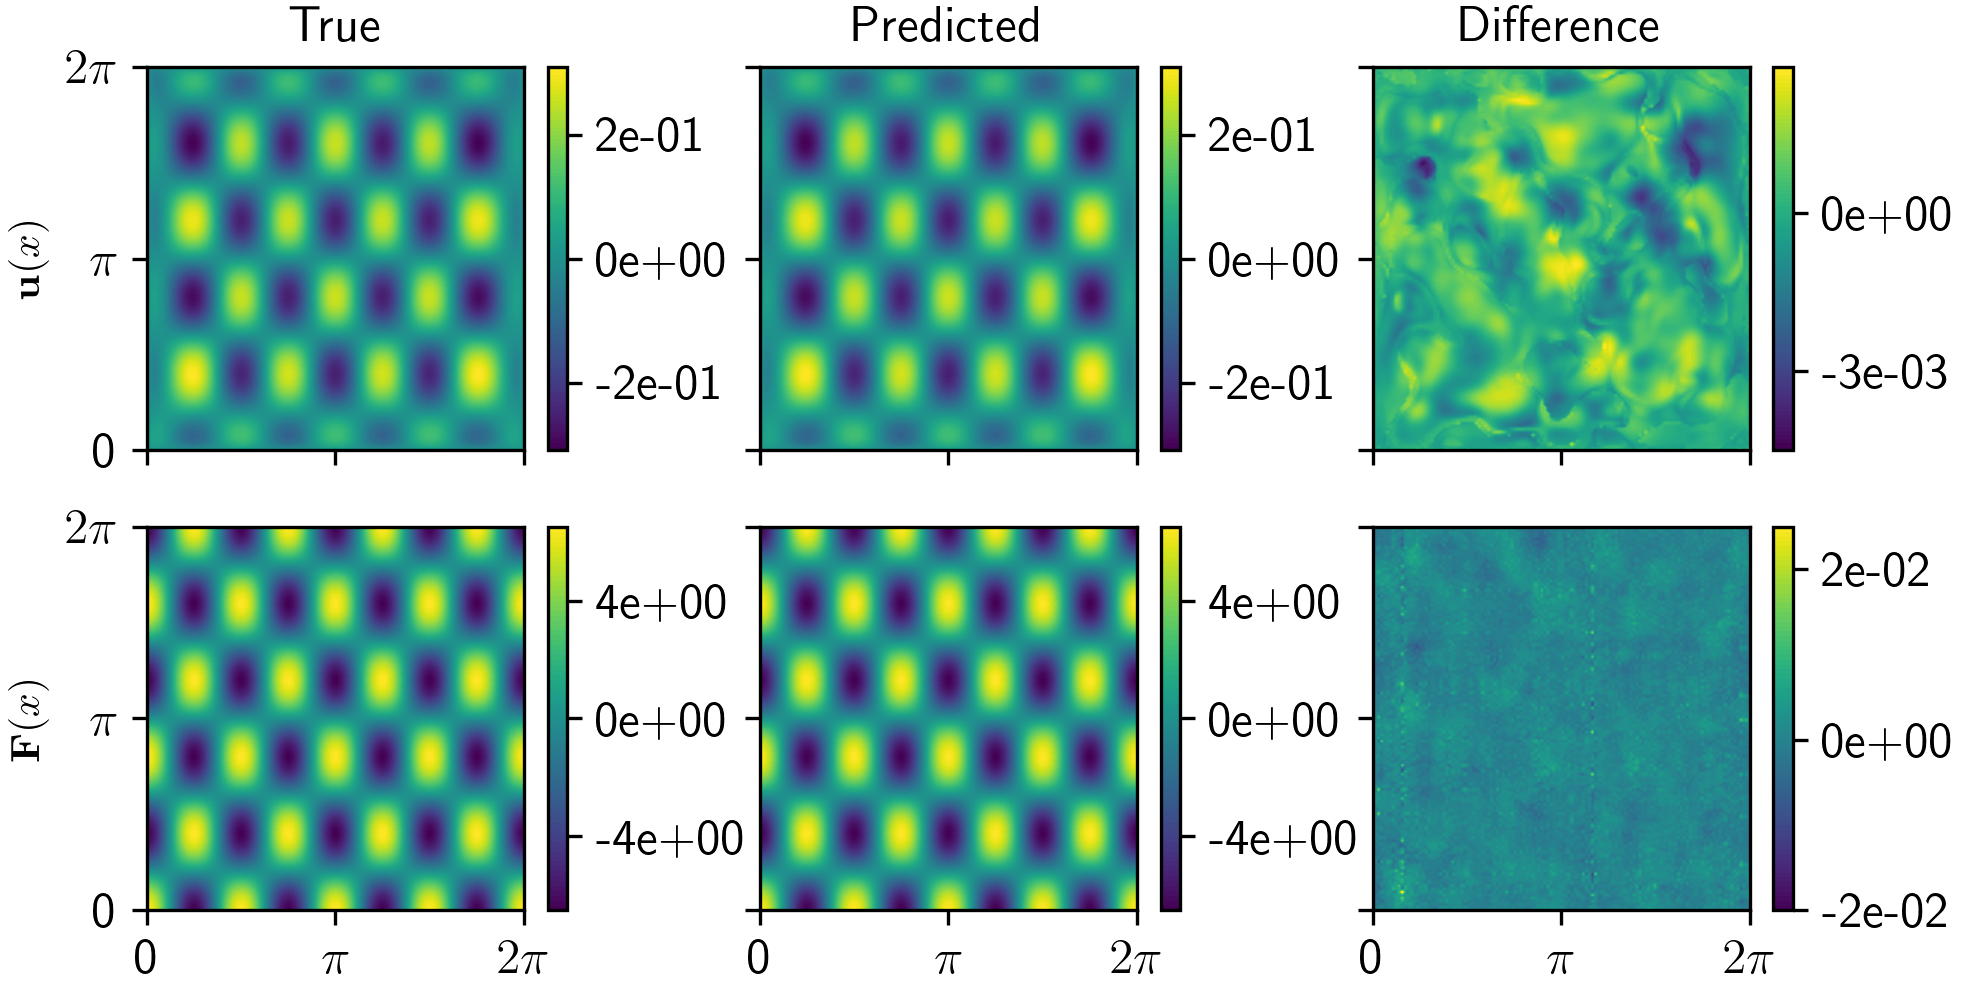

Min u: -8.58e-01
Max u: 2.36e+00
Min F: -9.90e+00
Max F: 9.95e+00
Min u difference: -1.74e-02
Max u difference: 2.38e-02
Min F difference: -4.91e-02
Max F difference: 5.53e-02


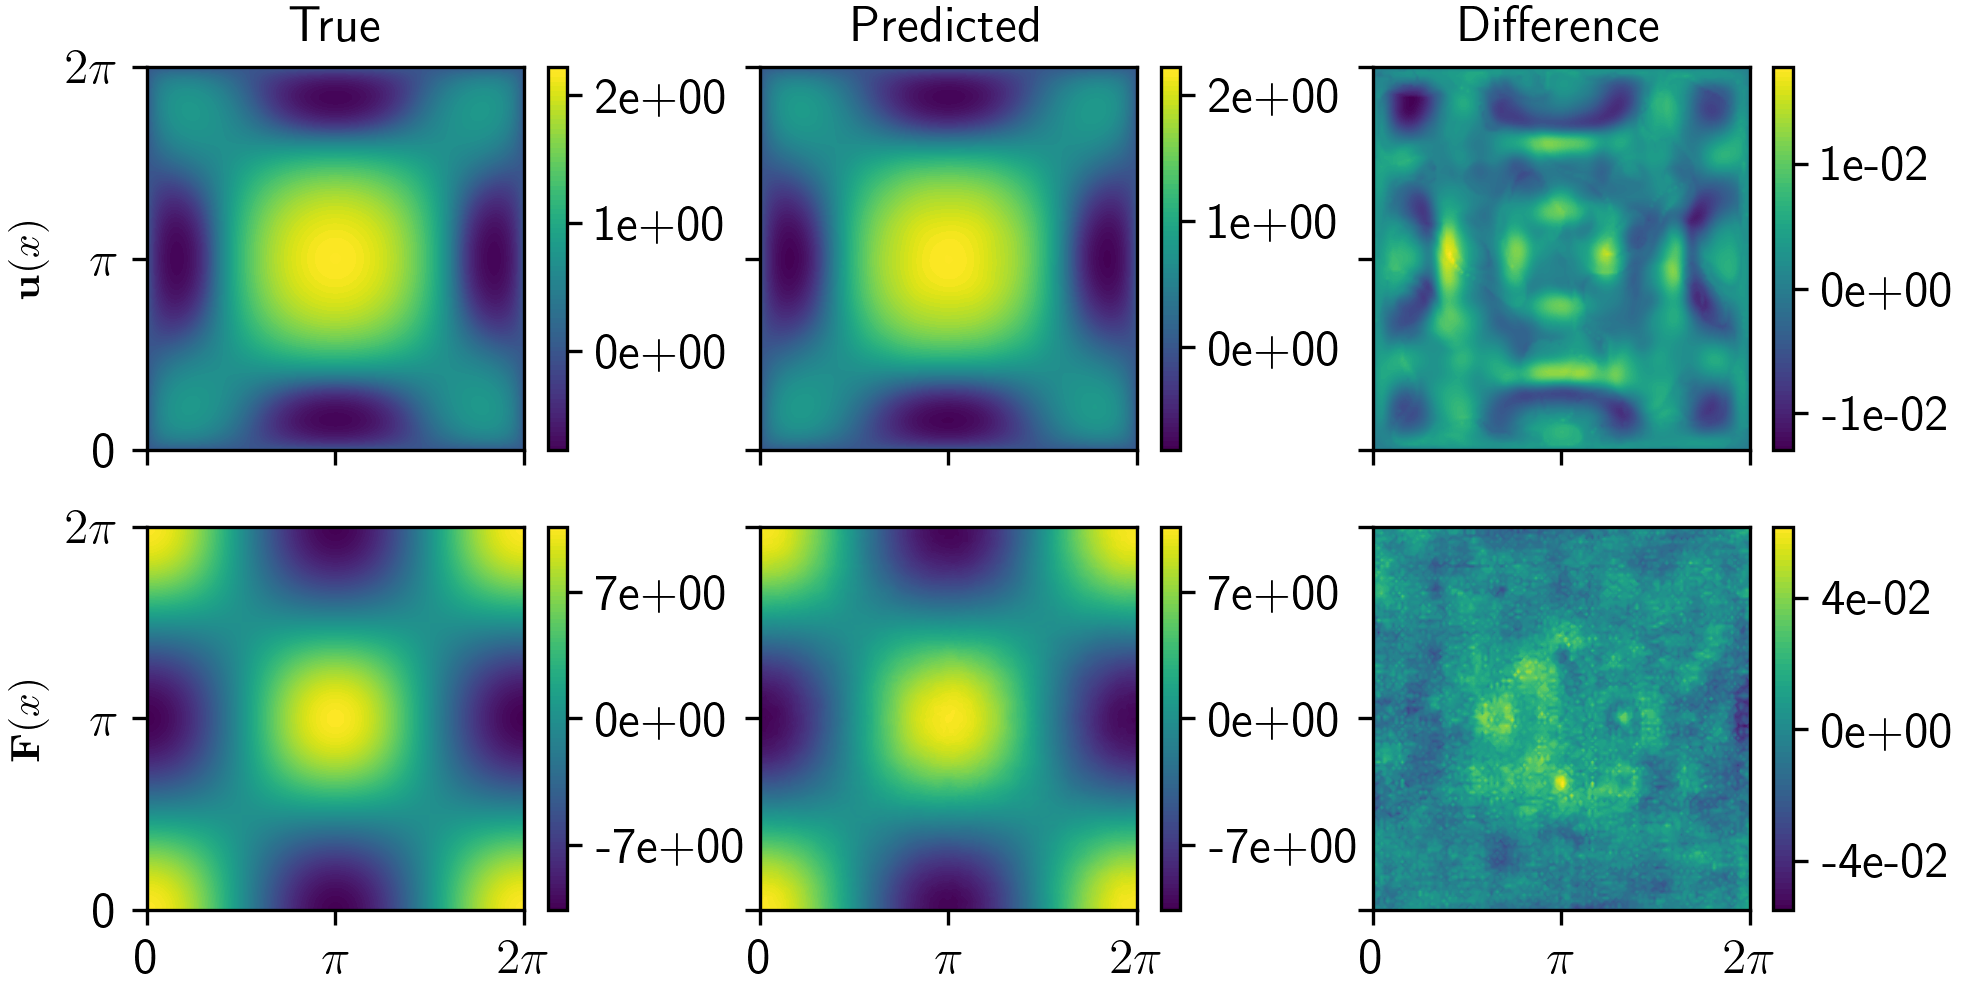

Min u: -8.28e-01
Max u: 3.23e-03
Min F: -9.29e+00
Max F: 6.73e-01
Min u difference: -7.02e-02
Max u difference: 4.83e-02
Min F difference: -9.69e-02
Max F difference: 4.64e-01


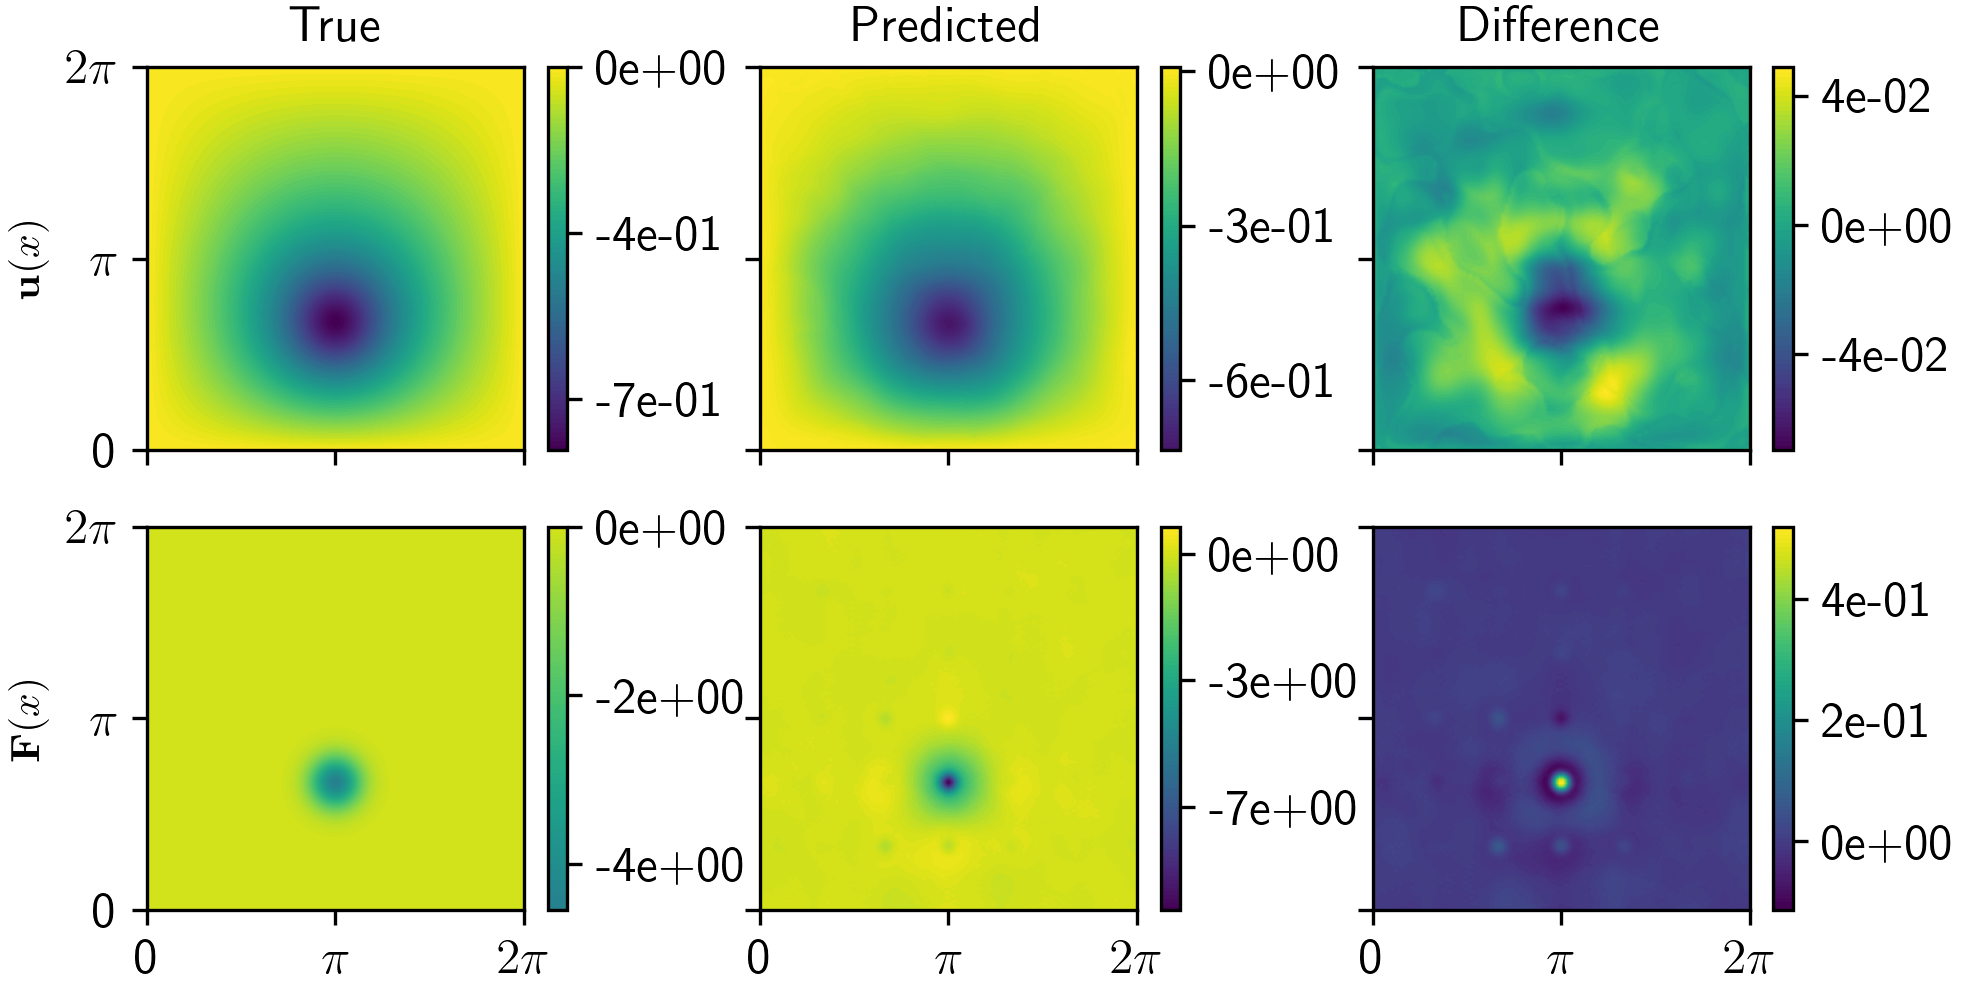

In [10]:
# Run to find reasonable values for the colorbars

plt.rcdefaults()
plt.rcParams.update(full_params)

generate_compare_plot(expt, 'test1', saveallfigs=False)

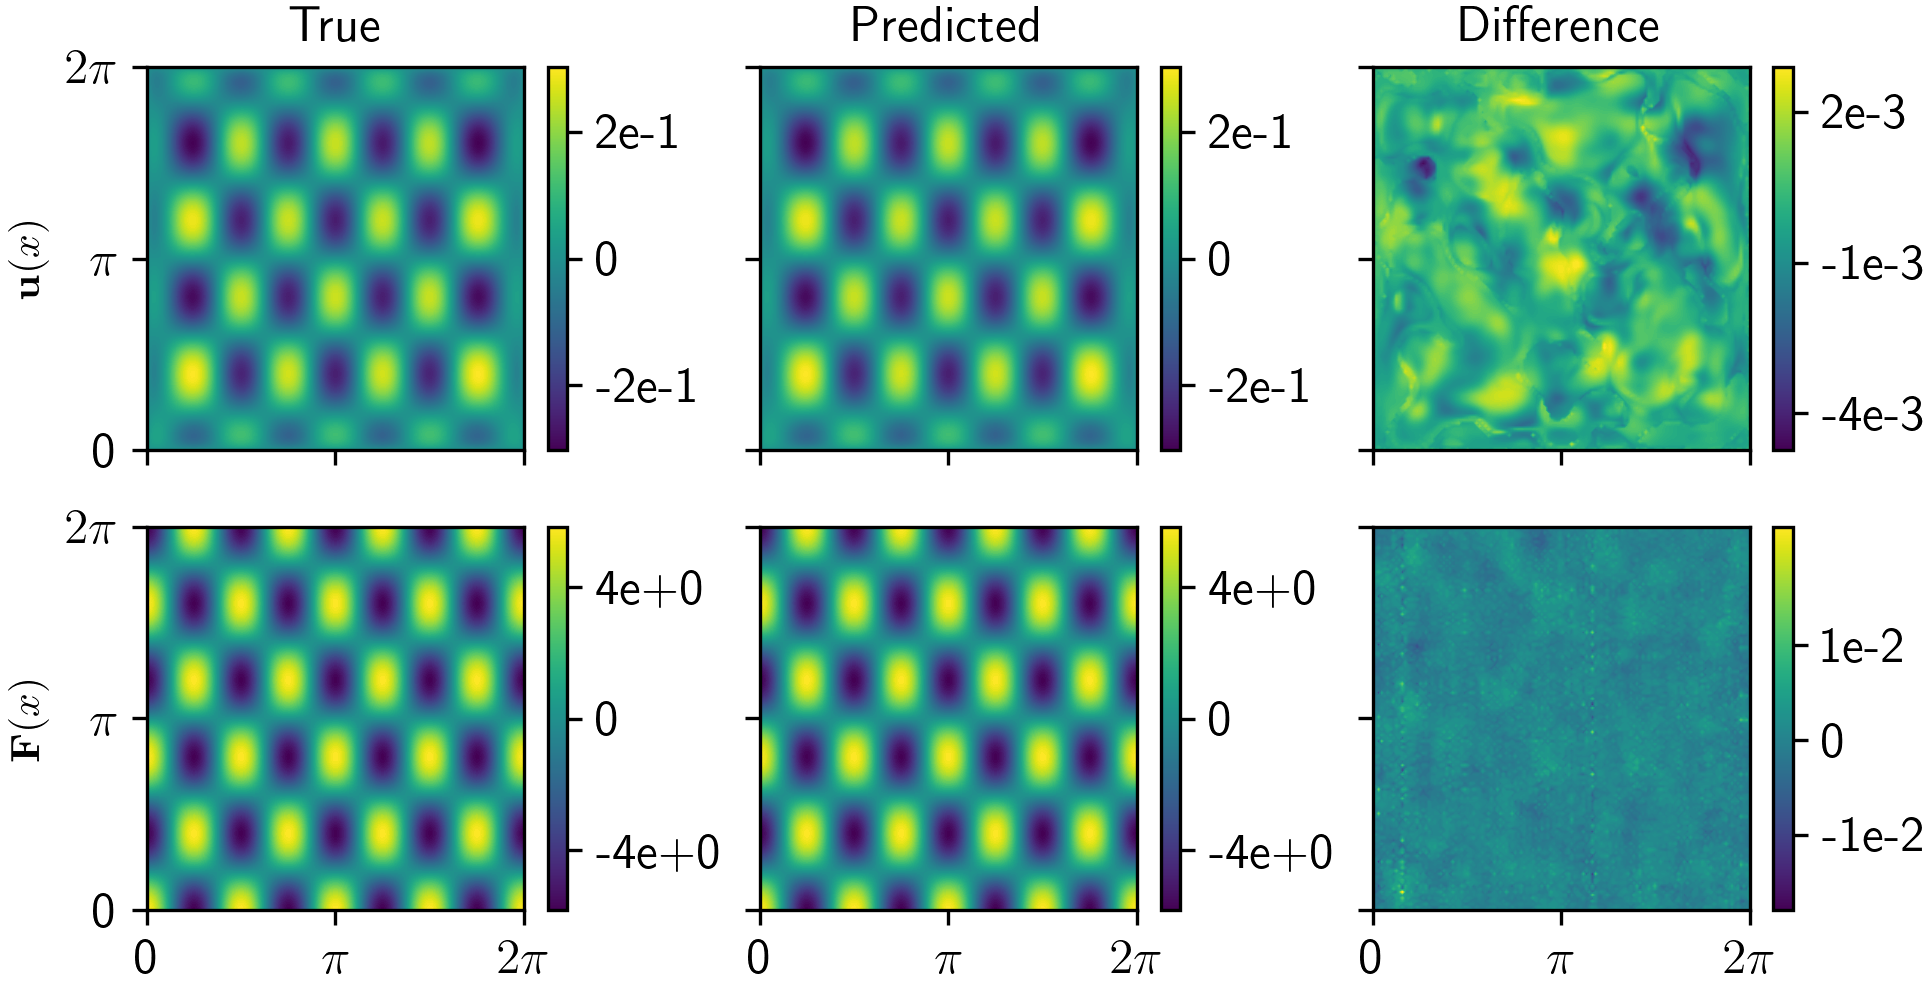

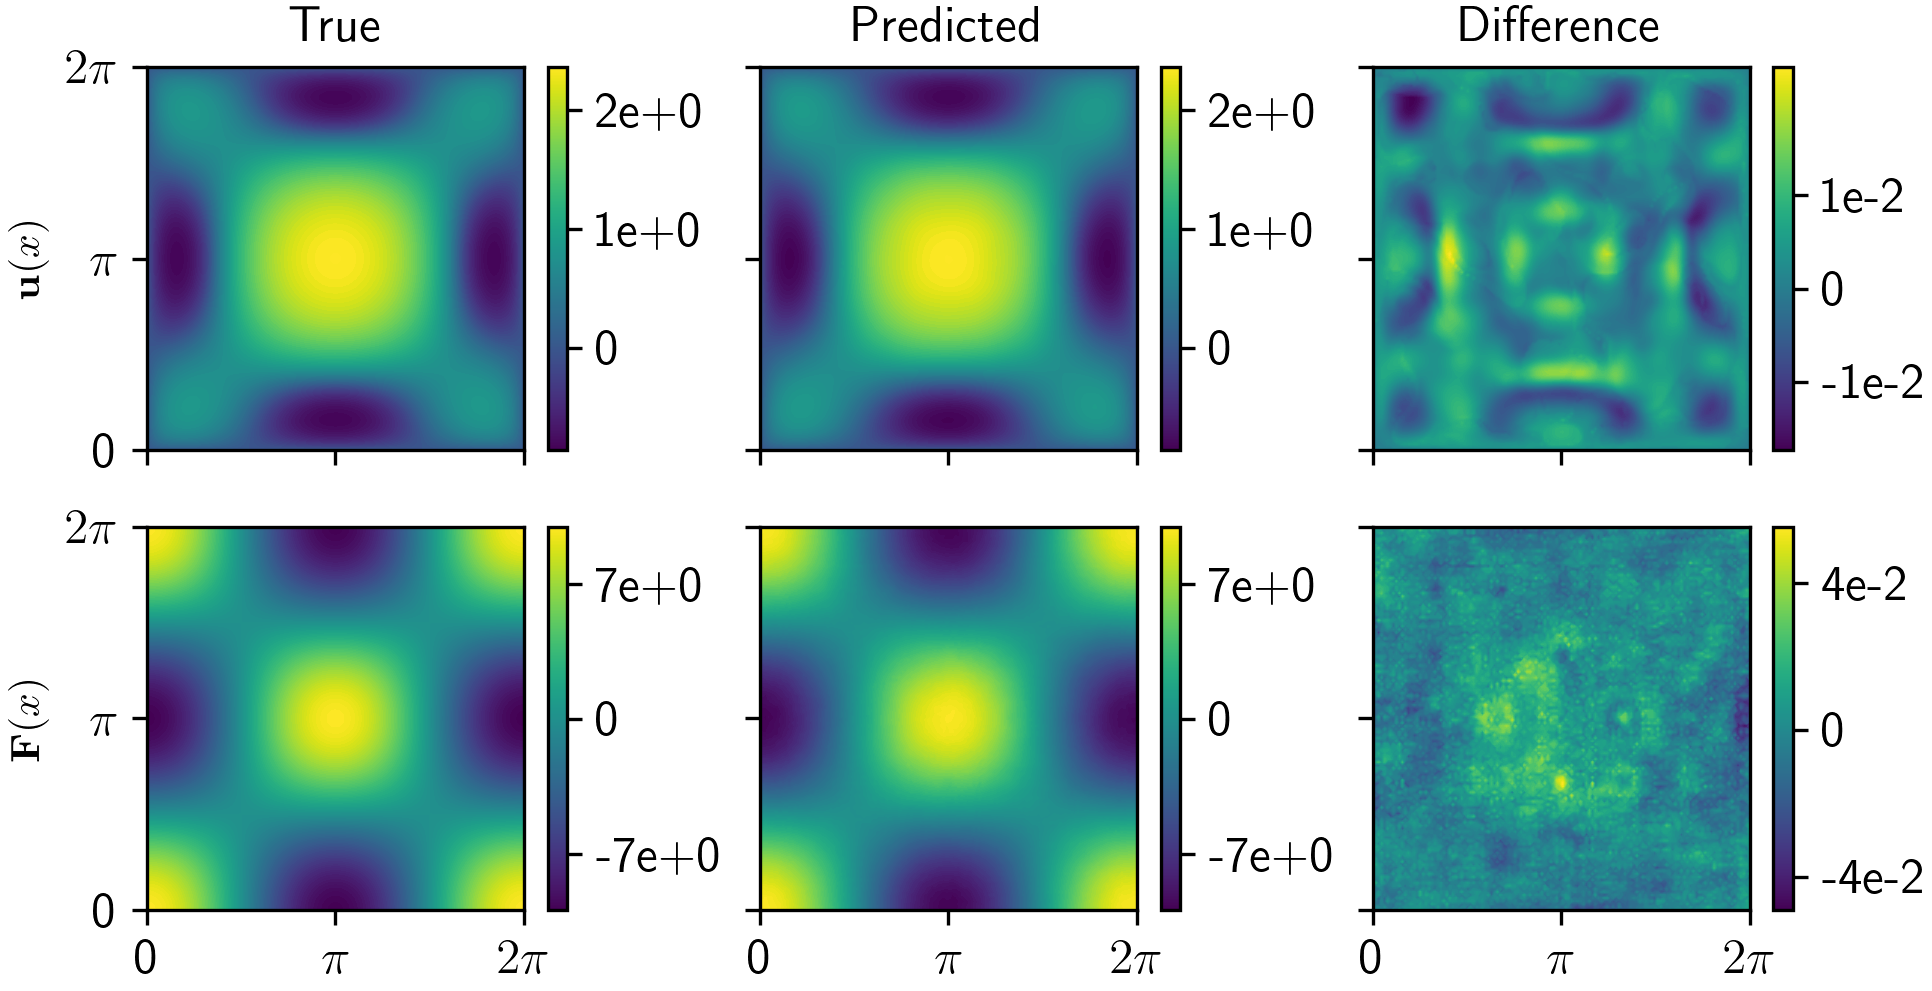

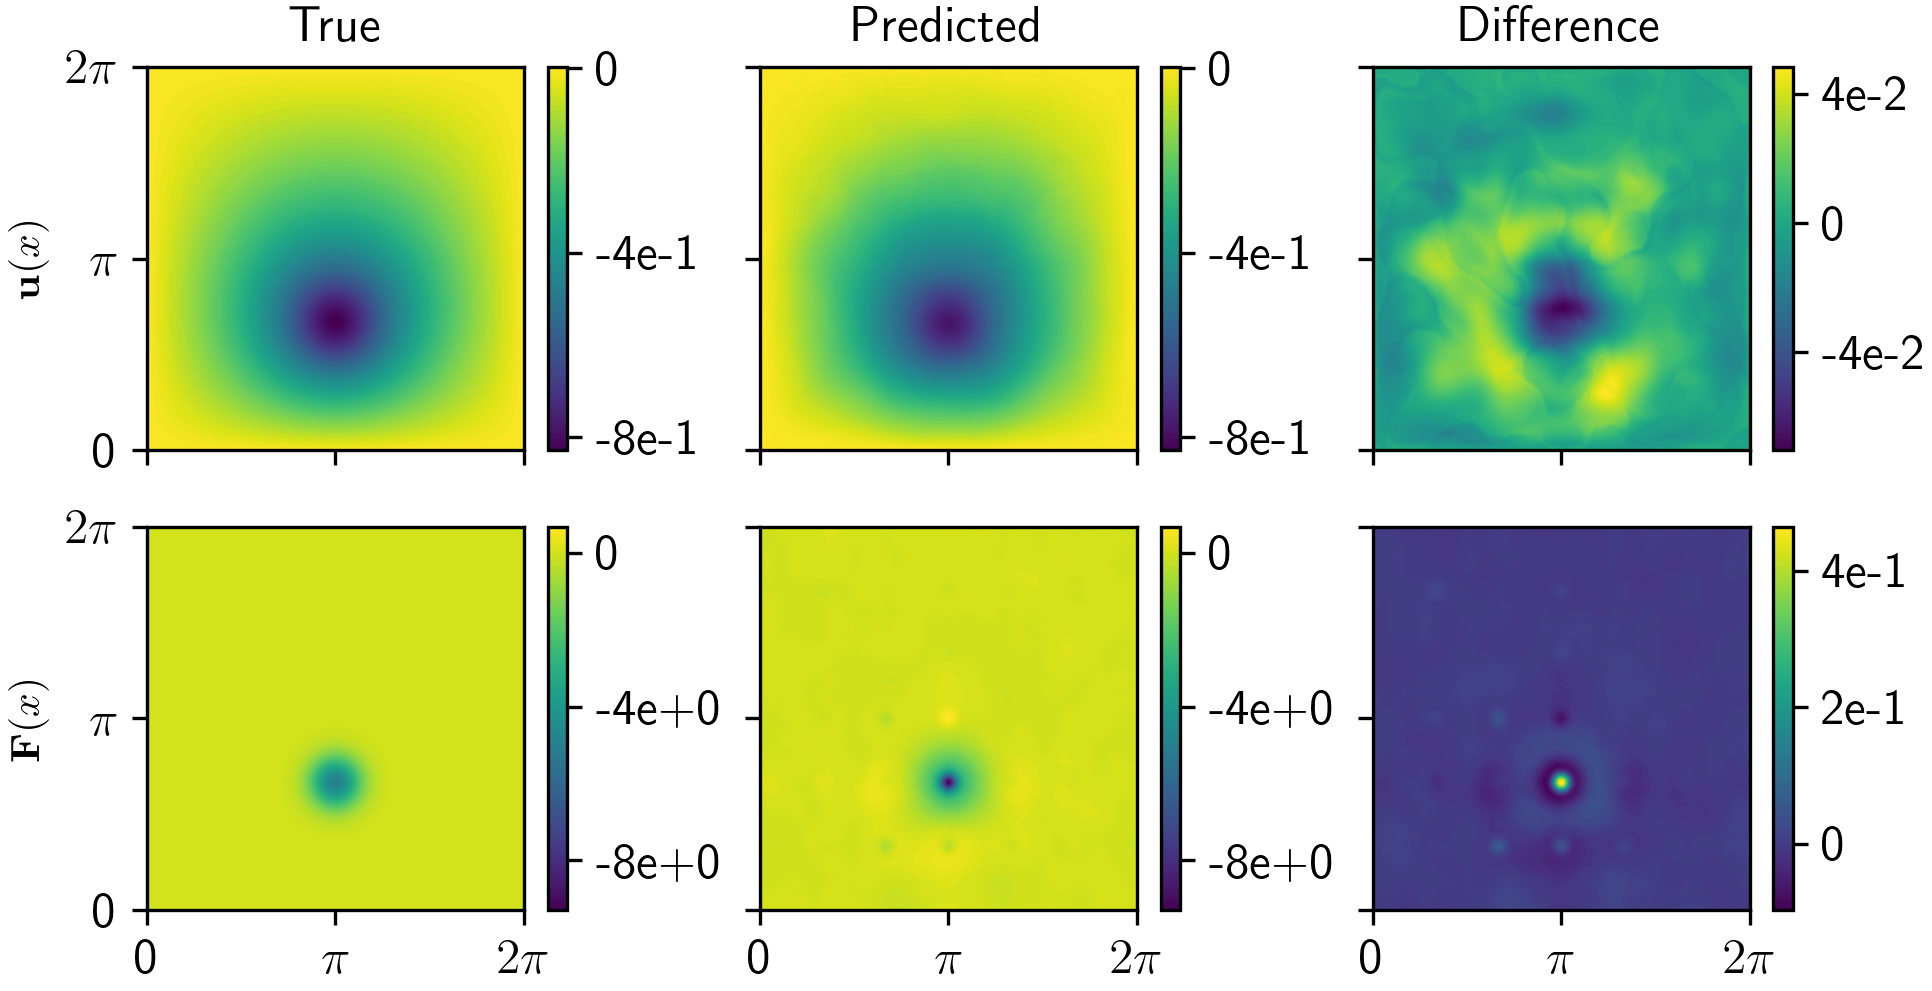

In [19]:
# Now manually input the values for the colorbars to ensure equal spacing and proper formatting

plt.rcdefaults()
plt.rcParams.update(full_params)

cbticksu_best = ['-2e-1', '0', '2e-1'] 
cbticksF_best = ['-4e+0', '0', '4e+0'] 
cbticksDu_best = ['-4e-3', '-1e-3', '2e-3']
cbticksDF_best = ['-1e-2', '0', '1e-2']

cbticksu_mean = ['0', '1e+0', '2e+0'] 
cbticksF_mean = ['-7e+0', '0', '7e+0'] 
cbticksDu_mean = ['-1e-2', '0', '1e-2']
cbticksDF_mean = ['-4e-2', '0', '4e-2']

cbticksu_worst = ['-8e-1', '-4e-1', '0'] 
cbticksF_worst = ['-8e+0', '-4e+0', '0'] 
cbticksDu_worst = ['-4e-2', '0', '4e-2']
cbticksDF_worst = ['0', '2e-1', '4e-1']

cbticksu = [cbticksu_best, cbticksu_mean, cbticksu_worst]
cbticksF = [cbticksF_best, cbticksF_mean, cbticksF_worst]
cbticksDu = [cbticksDu_best, cbticksDu_mean, cbticksDu_worst]
cbticksDF = [cbticksDF_best, cbticksDF_mean, cbticksDF_worst]

generate_compare_plot(expt, 'test1', cbticksu, cbticksF, cbticksDu, cbticksDF, saveallfigs)

Min u: -3.18e+00
Max u: 3.05e-03
Min F: -5.14e+00
Max F: -3.00e+00
Min u difference: -5.13e-03
Max u difference: 7.87e-03
Min F difference: -6.40e-02
Max F difference: 6.15e-02


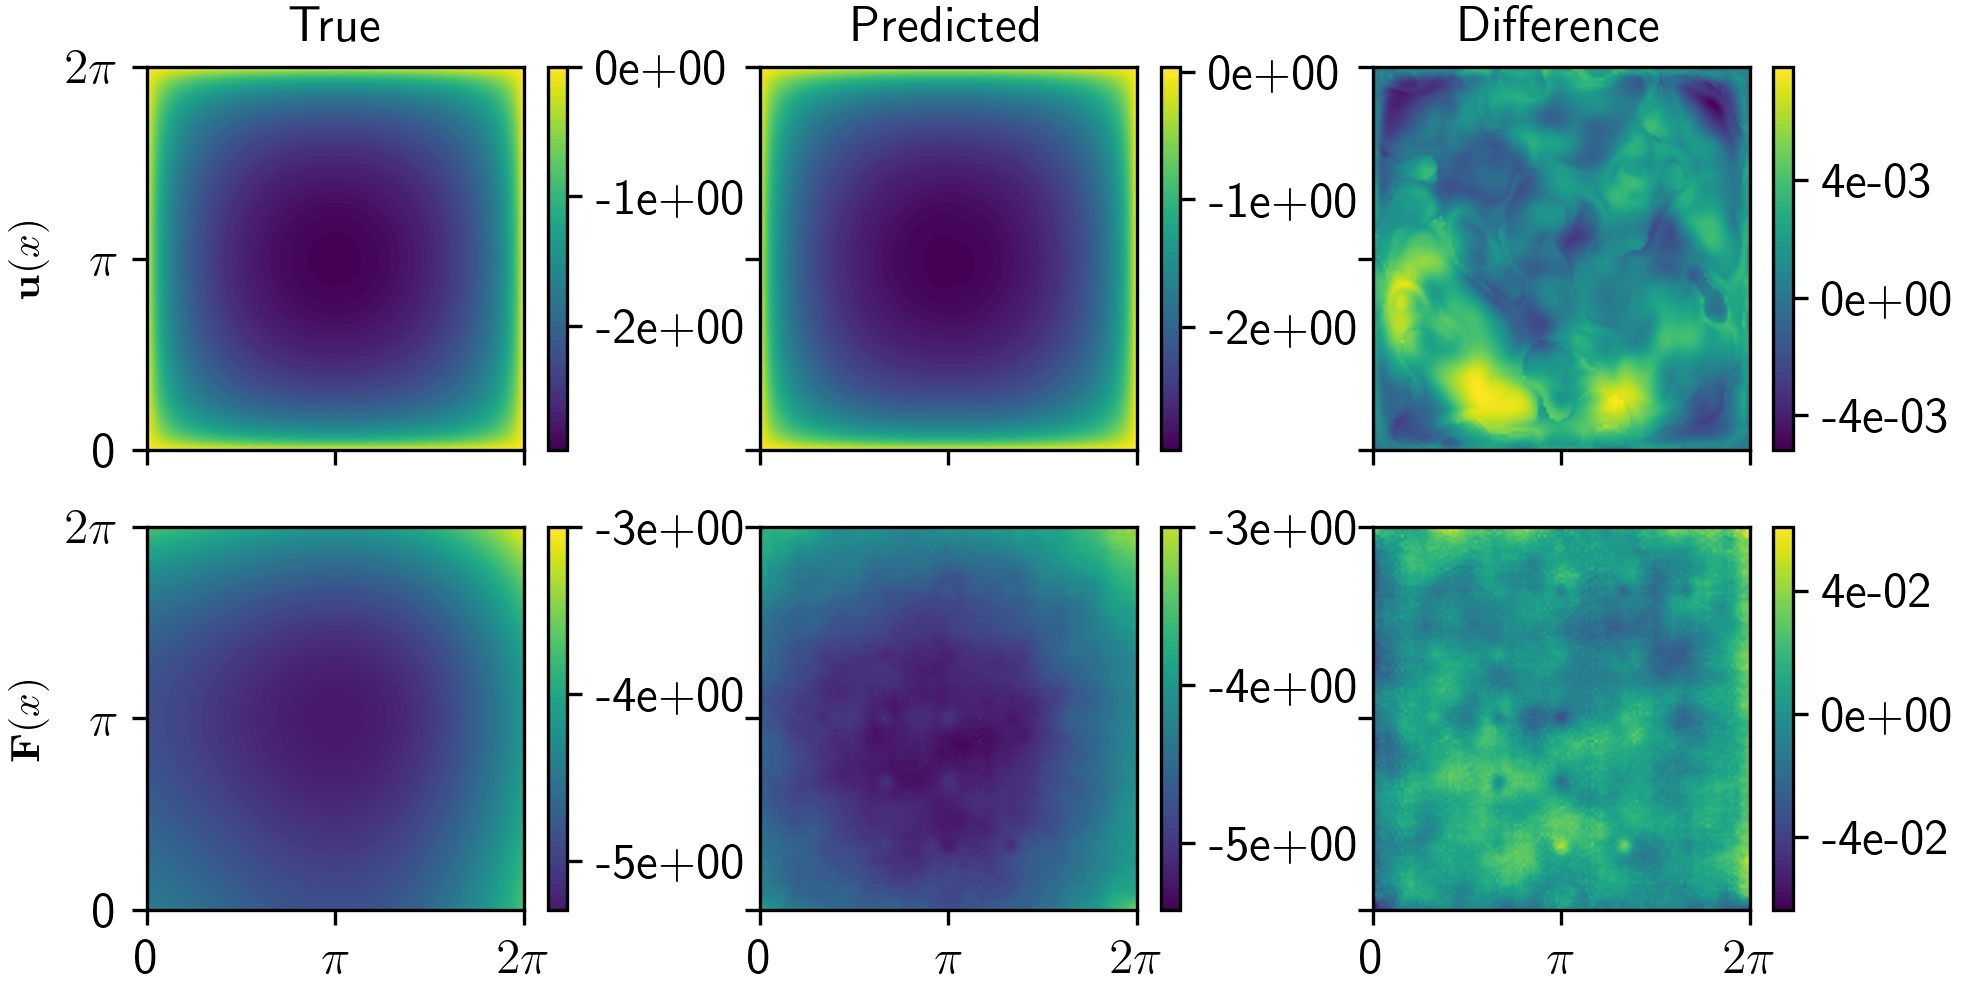

Min u: -2.82e+00
Max u: 6.56e-01
Min F: -1.67e+01
Max F: 1.35e+01
Min u difference: -1.96e-01
Max u difference: 8.97e-02
Min F difference: -3.50e-01
Max F difference: 3.21e-01


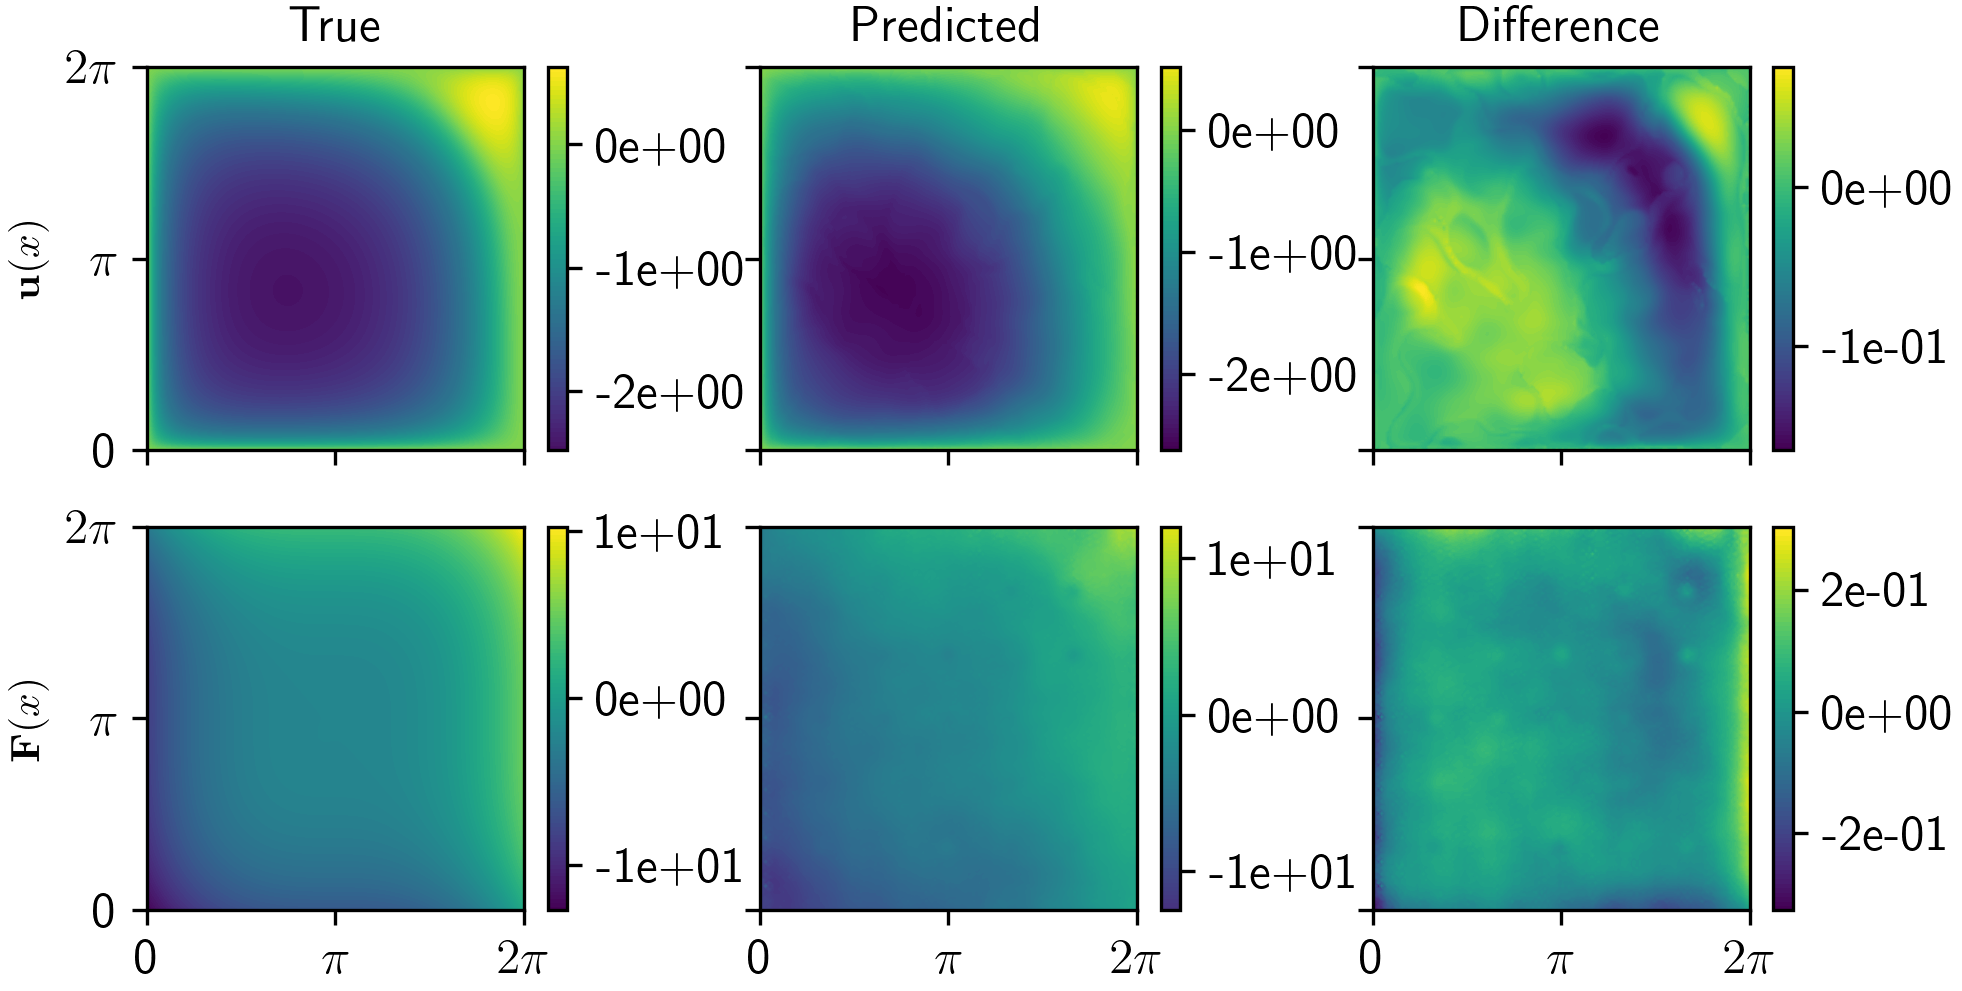

Min u: -2.13e-01
Max u: 2.57e-01
Min F: -6.20e-01
Max F: 6.20e-01
Min u difference: -5.54e-01
Max u difference: 4.02e-01
Min F difference: -6.46e-01
Max F difference: 3.75e-01


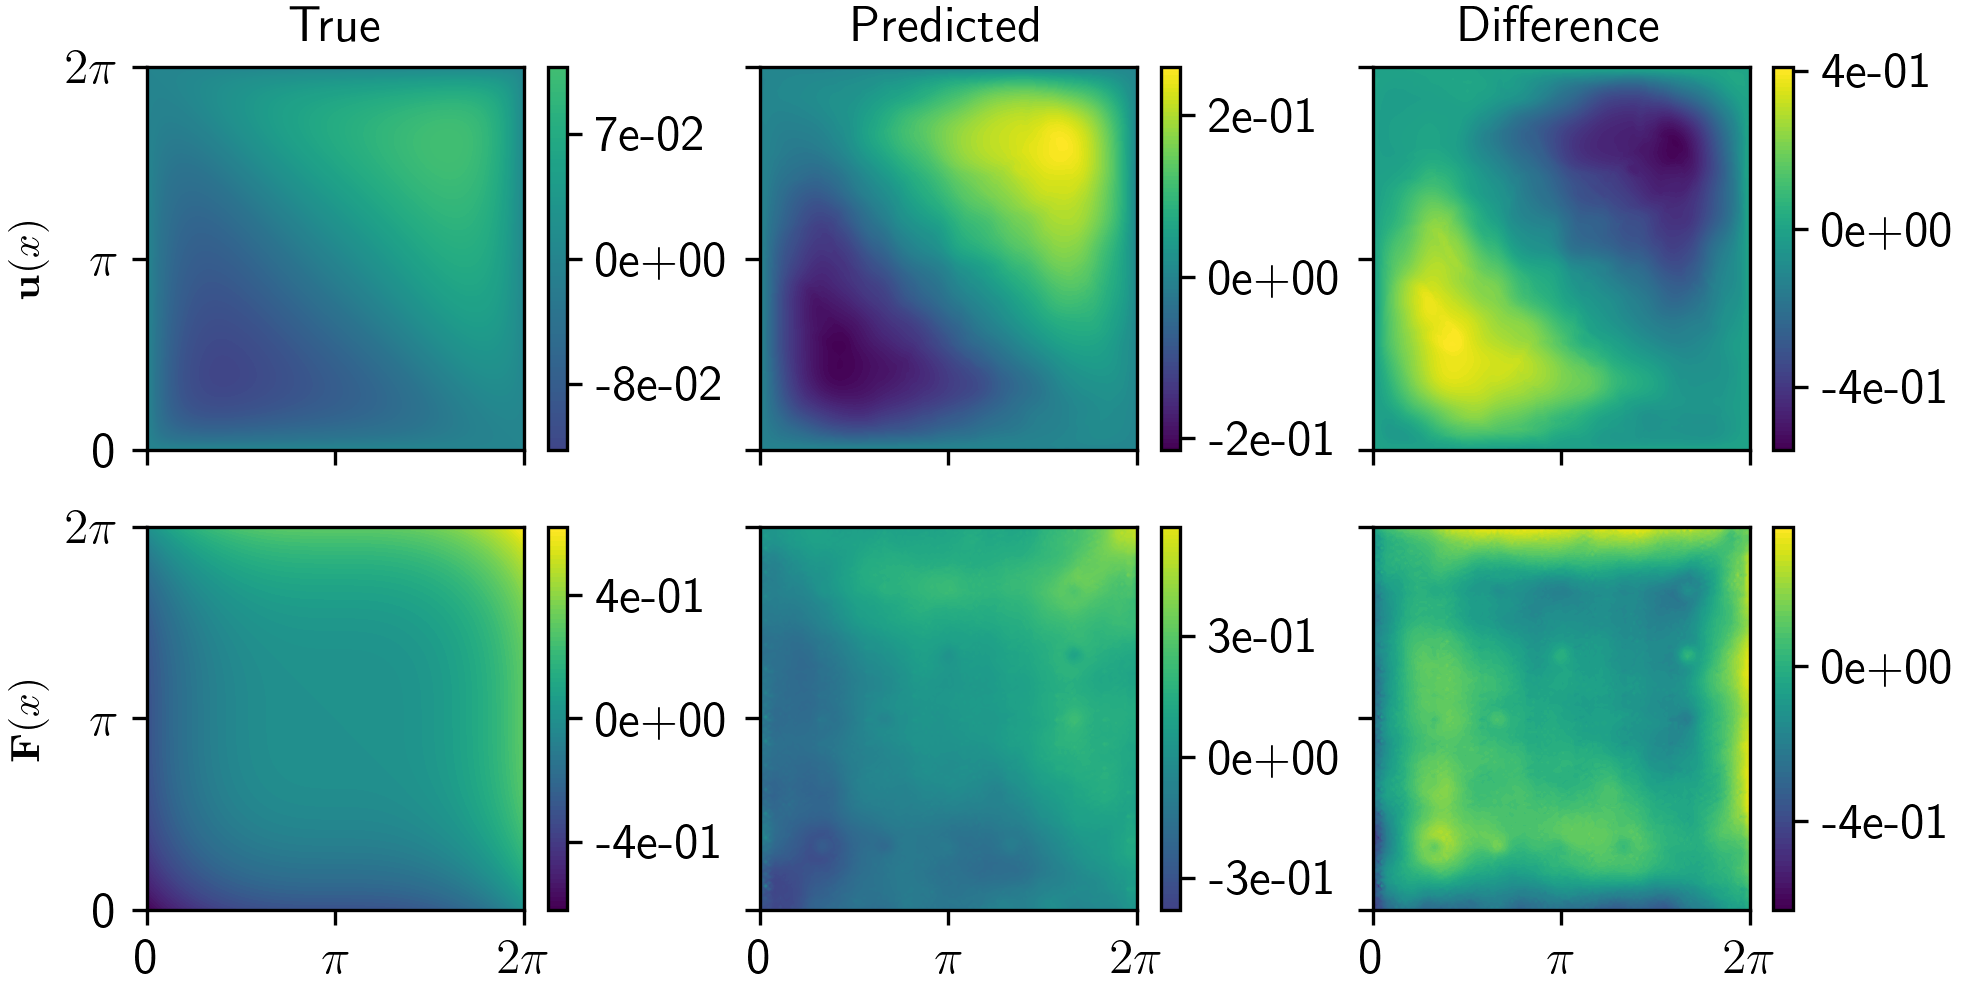

In [12]:
# Run to find reasonable values for the colorbars

plt.rcdefaults()
plt.rcParams.update(full_params)

generate_compare_plot(expt, 'test2', saveallfigs=False)

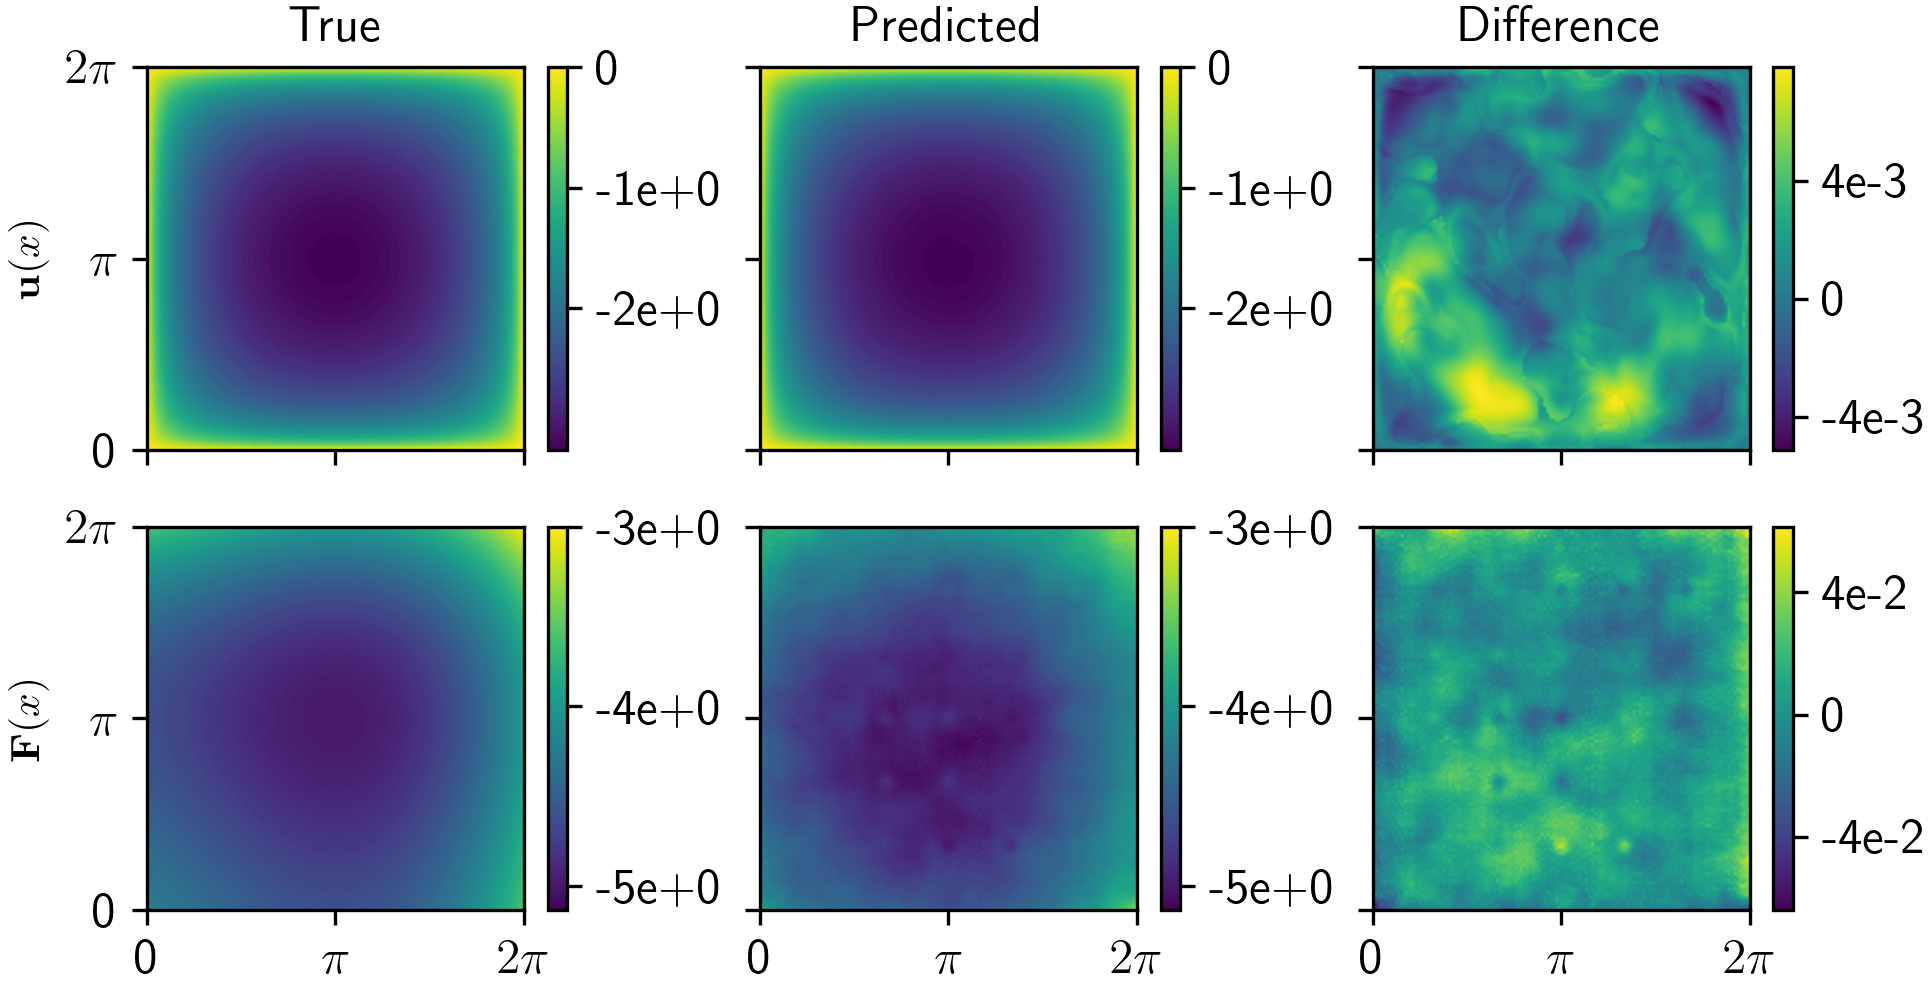

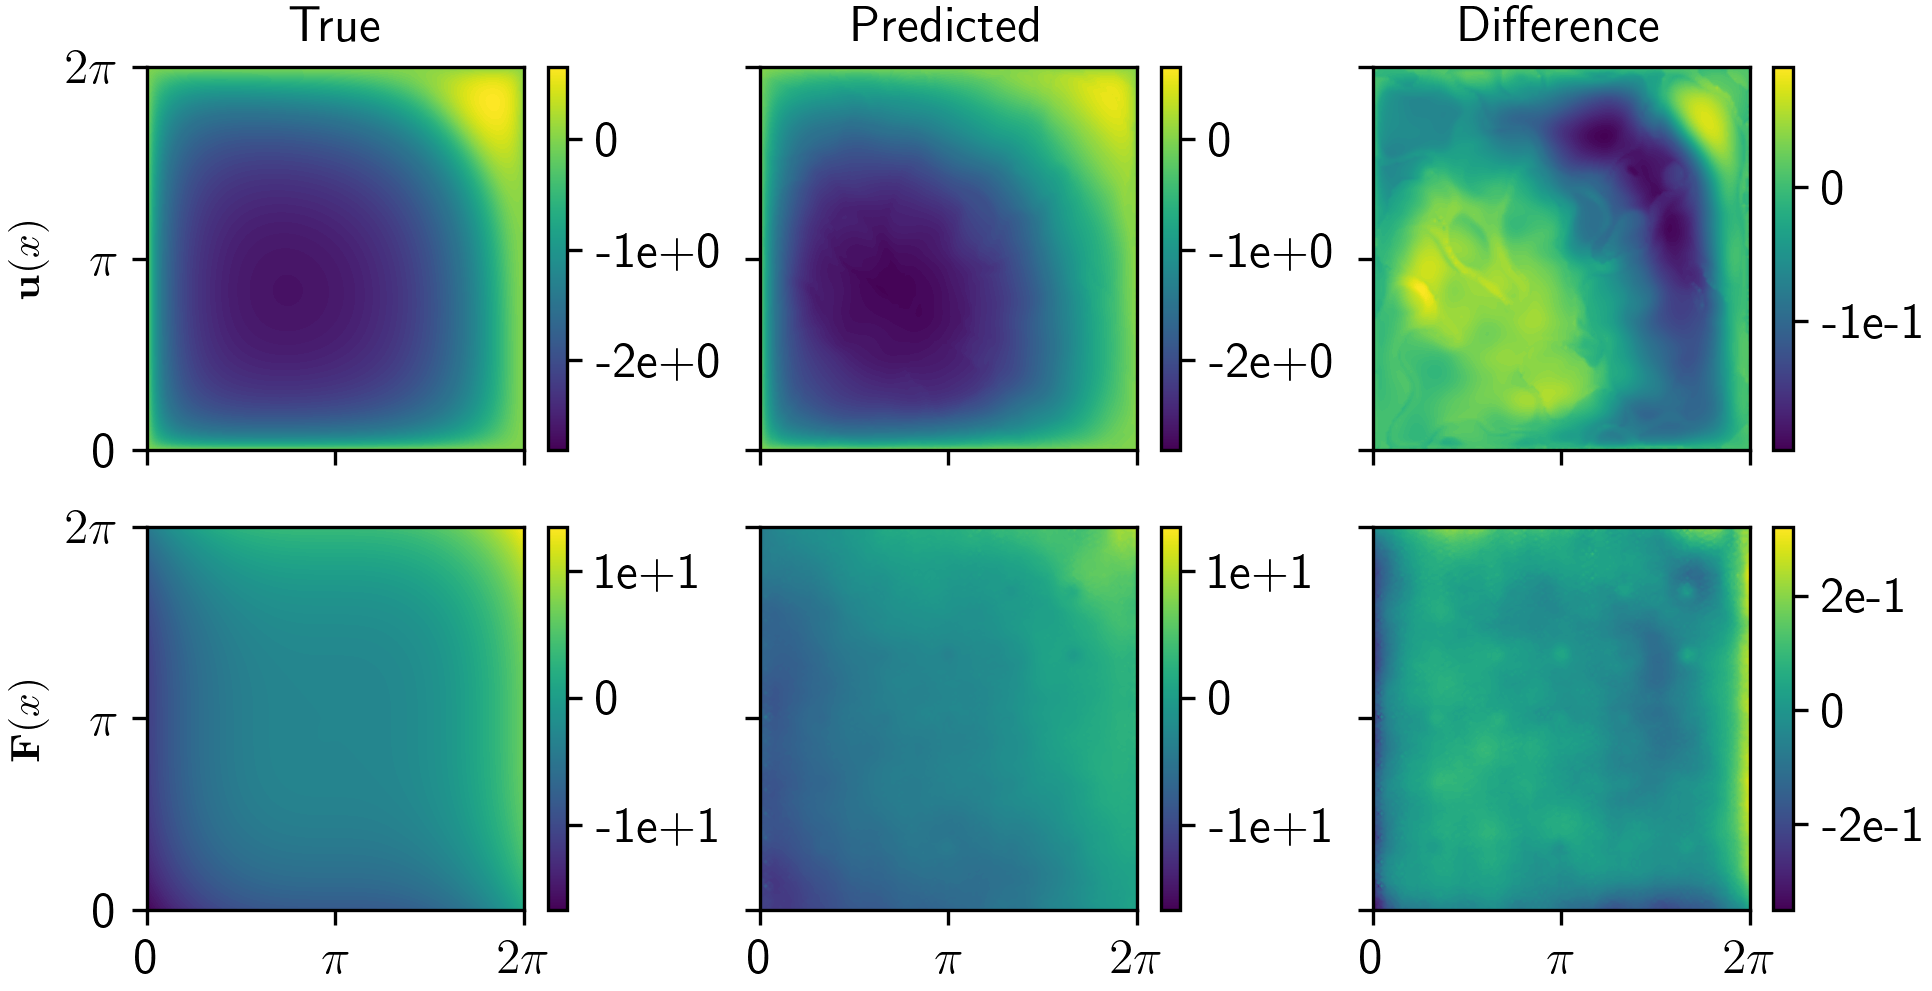

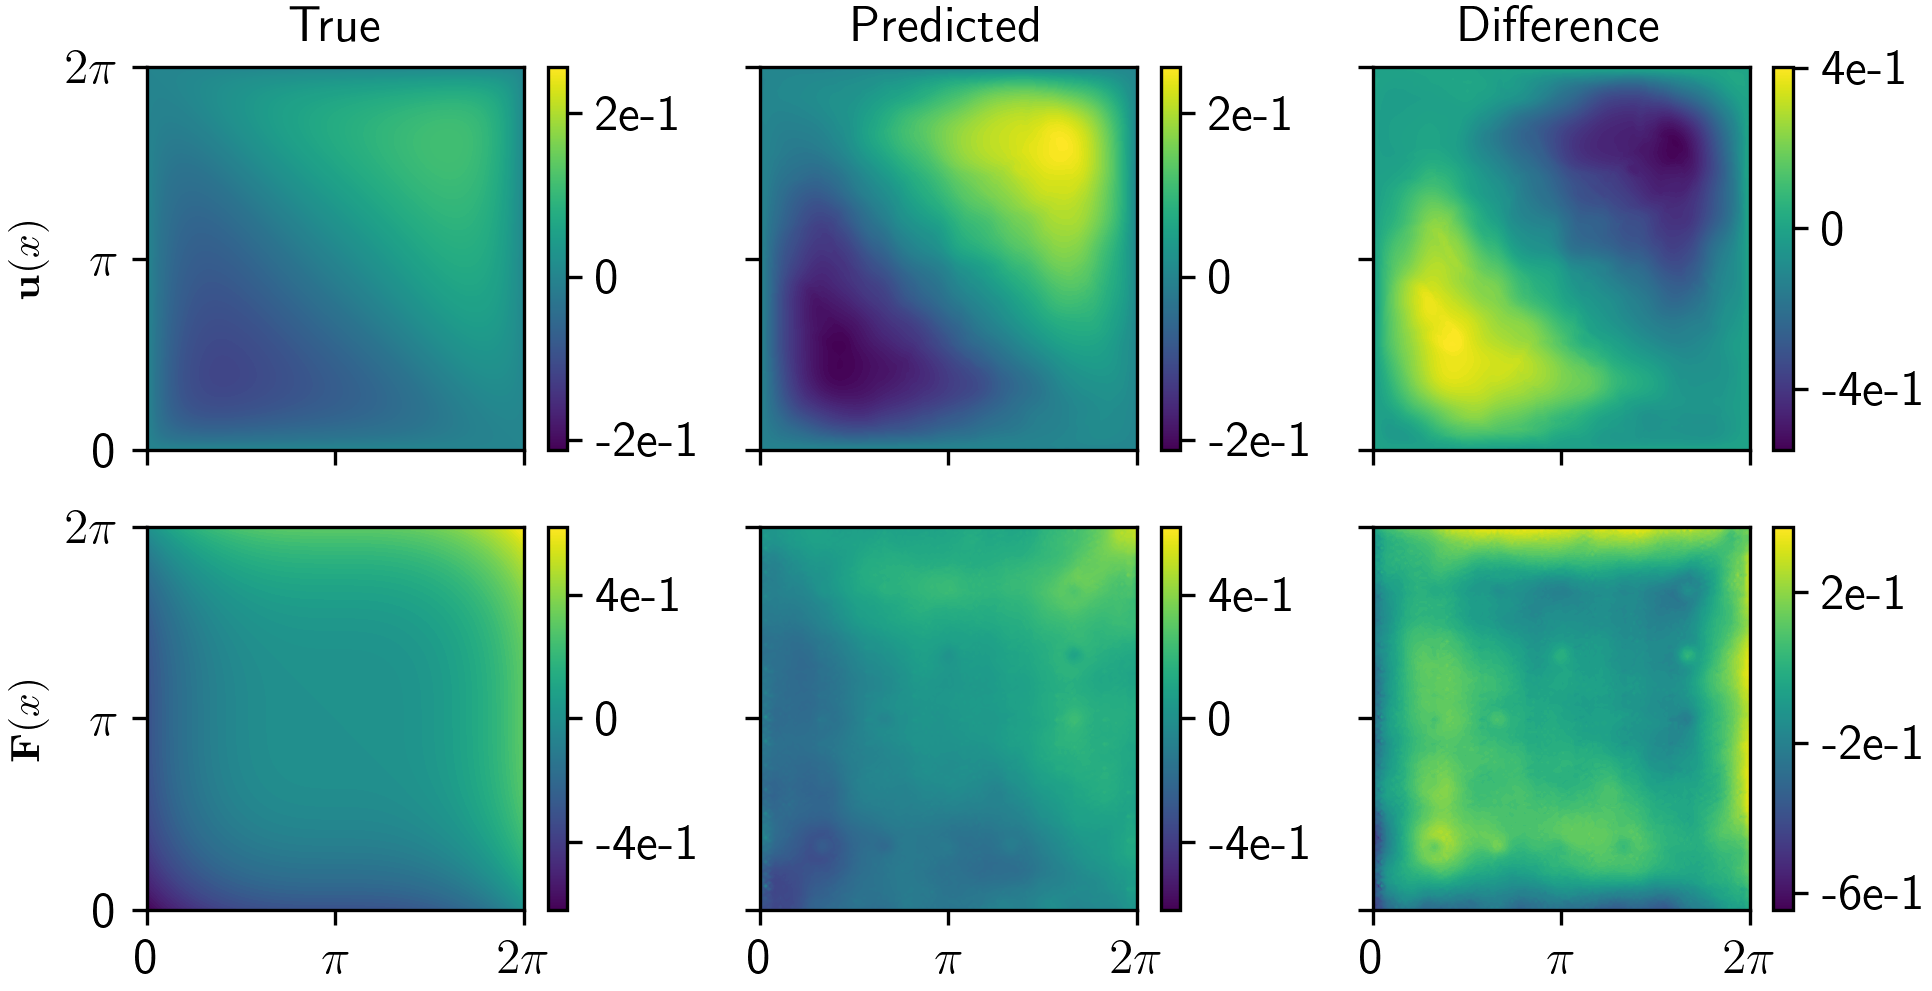

In [13]:
# Now manually input the values for the colorbars to ensure equal spacing and proper formatting

plt.rcdefaults()
plt.rcParams.update(full_params)

cbticksu_best = ['-2e+0', '-1e+0', '0'] 
cbticksF_best = ['-5e+0', '-4e+0', '-3e+0'] 
cbticksDu_best = ['-4e-3', '0', '4e-3']
cbticksDF_best = ['-4e-2', '0', '4e-2']

cbticksu_mean = ['-2e+0', '-1e+0', '0'] 
cbticksF_mean = ['-1e+1', '0', '1e+1'] 
cbticksDu_mean = ['-2e-1', '-1e-1', '0']
cbticksDF_mean = ['-2e-1', '0', '2e-1']

cbticksu_worst = ['-2e-1', '0', '2e-1'] 
cbticksF_worst = ['-4e-1', '0', '4e-1'] 
cbticksDu_worst = ['-4e-1', '0', '4e-1']
cbticksDF_worst = ['-6e-1', '-2e-1', '2e-1']

cbticksu = [cbticksu_best, cbticksu_mean, cbticksu_worst]
cbticksF = [cbticksF_best, cbticksF_mean, cbticksF_worst]
cbticksDu = [cbticksDu_best, cbticksDu_mean, cbticksDu_worst]
cbticksDF = [cbticksDF_best, cbticksDF_mean, cbticksDF_worst]

generate_compare_plot(expt, 'test2', cbticksu, cbticksF, cbticksDu, cbticksDF, saveallfigs)

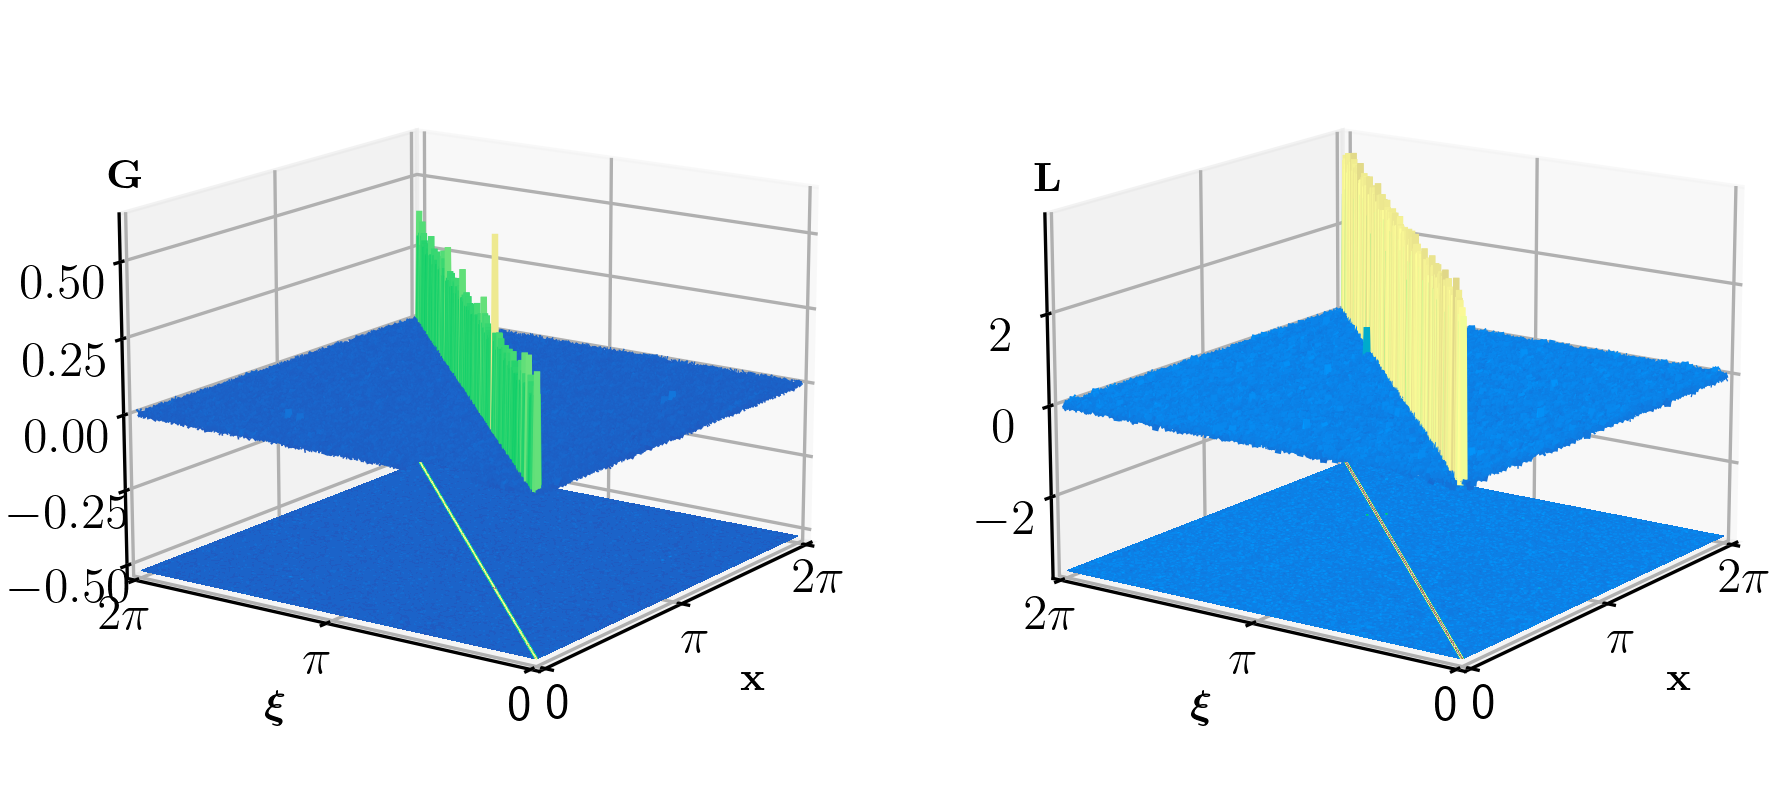

In [14]:
plt.rcdefaults()
plt.rcParams.update(full_params)

generate_GL_plot(expt)

if saveallfigs:
    plt.savefig("{}-L_and_G.png".format(expt.name), transparent=True)
    
plt.show()

In [15]:
def latent_space_plot(expt, index, dataset_name='train1'):
    # Set up the plotting vectors
    v, f = expt.encode_vf(index=index, dataset_name='train1')
    x = np.linspace(0, 2*np.pi, f.shape[0])

    # Some plotting options
    aec_line = dict(color='orange', lw=2, mfc='orange')
    aec_line2 = dict(color='cornflowerblue', lw=1, mfc='cornflowerblue')
    #aec_line = dict(color='orange', marker='o', mfc='orange', mec='black')
    #aec_line2 = dict(color='cornflowerblue', marker='d', mfc='cornflowerblue', mec='black')

    # And now plot it!
    fig = plt.figure()

    #Plot the v and f vectors
    plt.plot(x, v, **aec_line, label=r'$\boldsymbol{\psi}_u \mathbf{u}(\mathbf{x})$')
    plt.plot(x, f, **aec_line2, label=r'$\boldsymbol{\psi}_F \mathbf{F}(\mathbf{x})$')
    
    #Place the legend and label the axes
    plt.legend(loc='lower left')
    plt.ylabel(r"$\mathbf{f}(\mathbf{x})$, $\mathbf{v}(\mathbf{x})$")
    plt.xlabel(r"$\mathbf{x}$")

    # Format x-axis
    plt.xlabel(r"$\mathbf{x}$")
    plt.xticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"])
    plt.xlim([0,2*np.pi])


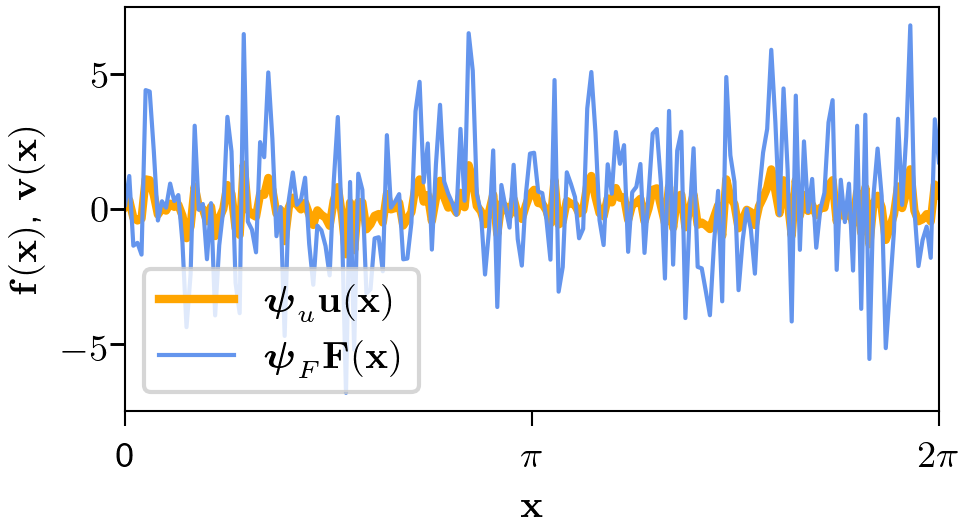

In [16]:
plt.rcdefaults()
plot_params = half_params.copy()
plot_params['figure.figsize'] = (3.5,1.75)
plt.rcParams.update(plot_params)

i = expt.find_sample(dataset_name='train1', mode='Mean')
latent_space_plot(expt, index=i, dataset_name='train1')

if saveallfigs:
    plt.savefig("{}-latentspace.png".format(expt.name), transparent=True)

plt.show()

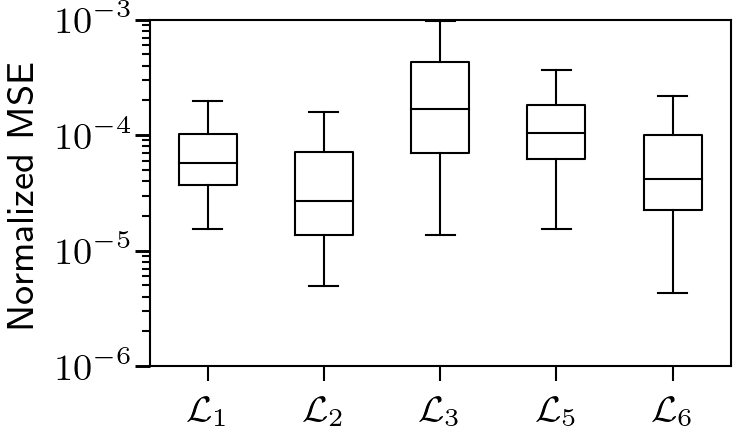

In [7]:
plt.rcdefaults()
plot_params = half_params.copy()
plot_params.update(boxplot_params)
plot_params['figure.figsize'] = (2.5, 1.5)
plt.rcParams.update(plot_params)

loss_boxplot(expt, dataset_name='test1')

# Save, if saving figures
if saveallfigs:
    plt.savefig("{}-boxplot.svg".format(expt.name))

plt.show()

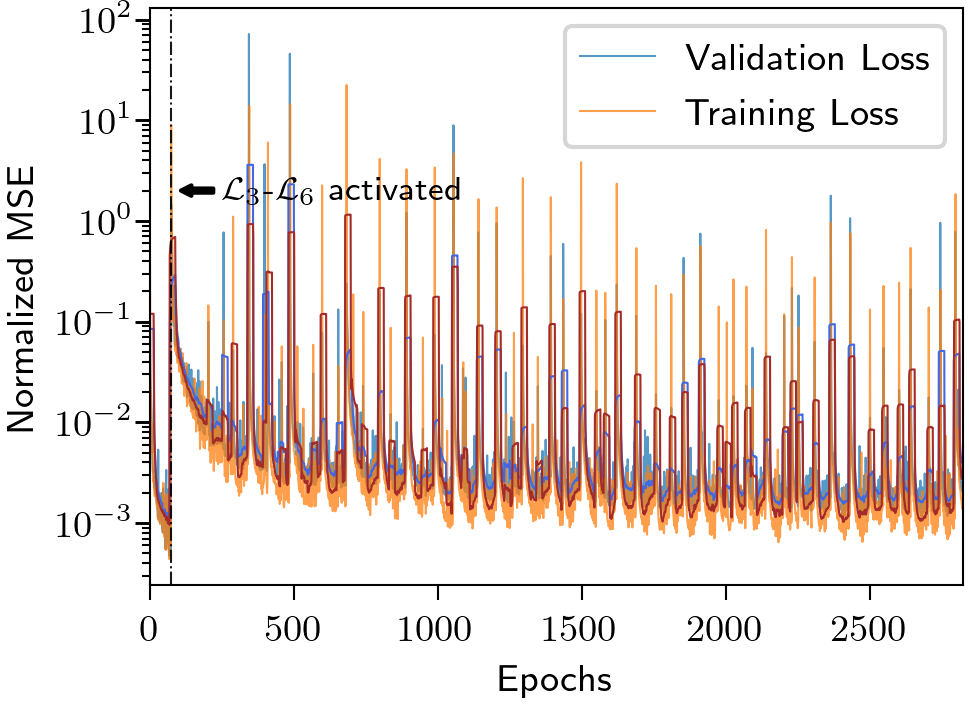

In [18]:
# Set up plotting options
plt.rcdefaults()
plot_params = half_params.copy()
plot_params['lines.linewidth'] = 0.5
plot_params['font.size'] = 8
plt.rcParams.update(plot_params)

###########################
## Val/Train Loss Curves
###########################
training_loss_epochs_plot(expt, roll_window=20)

if saveallfigs:
    plt.savefig("{}-TrainingLoss.png".format(expt.name), transparent=True)

plt.show()